The purpose of this notebook is to combine all retina data from the [Rodent Research 9](https://osdr.nasa.gov/bio/repo/data/payloads/RR-9) (RR9) mission from the [NASA Open Science Data Repository](https://www.nasa.gov/osdr/ (OSDR)), perform exploratory data analysis, and train a digital twin.

Testing needs to be done to see whether a larger synthetic dataset should be generated prior to digital twin training; and the ML model for the digital twin has not been identified yet.

Future work could also include incorporating the raw image data from [OSD-568](https://osdr.nasa.gov/bio/repo/data/studies/OSD-568) and [OSD-557](https://osdr.nasa.gov/bio/repo/data/studies/OSD-557), and environmental data from RR-9 (https://visualization.osdr.nasa.gov/eda/).


Feel free to make a copy of this notebook and change or add to it. Fill in your name below.

**Original Author:** Lauren Sanders

**Additional Author(s):**

# Data Preparation

Combine and merge 5 RR-9 datasets with different measurements on the mouse retina. Not all measurements are available for all samples (see the [RR9 Sample and Dataset sheet](https://docs.google.com/spreadsheets/d/1uZbj4rXpEWZJDywE7HAvwR5v7RNDtVyG/edit?gid=1036112252#gid=1036112252)).

1. [OSD-255](https://osdr.nasa.gov/bio/repo/data/studies/OSD-255): Gene expression quantification through RNA sequencing (right eye).

2. [OSD-568](https://osdr.nasa.gov/bio/repo/data/studies/OSD-568): Immunostaining quantification of 2 molecular markers related to blood-retinal barrier integrity: ZO1 and PECAM; and quantification of DNA damage from the TUNEL assay (left eye).

3. [OSD-557](https://osdr.nasa.gov/bio/repo/data/studies/OSD-557): Quantification of the [structure of the eye using microCT](https://pubmed.ncbi.nlm.nih.gov/33191924/); and immunostaining quantification of [PNA, a molecular marker for eye cone degradation](https://www.nature.com/articles/s41598-019-49453-x); and quantification of [H&E stain](https://en.wikipedia.org/wiki/H%26E_stain) for different cell components (left eye).

4. [OSD-583](https://osdr.nasa.gov/bio/repo/data/studies/OSD-583): Quantification of intra-ocular pressure through tonometry (both eyes).

5. [OSD-715](https://osdr.nasa.gov/bio/repo/data/studies/OSD-715): Protein expression quantification through mass spectrometry (left eye).

In [2]:
import pandas as pd
import requests
from skimpy import skim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from feature_engine.imputation import RandomSampleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import plotly.express as px
import random

In [3]:
## Using the Data API from the OSDR Public API
## Documentation: https://www.nasa.gov/reference/osdr-public-api/

rnaseq = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-255/download?source=datamanager&file=GLDS-255_rna_seq_Normalized_Counts.csv', index_col=0).transpose()

zo1 = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-568/download?source=datamanager&file=LSDS-5_immunostaining_microscopy_Zo-1tr_TRANSFORMED.csv')

tunel = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-568/download?source=datamanager&file=LSDS-5_immunostaining_microscopy_TUNELtr_TRANSFORMED.csv')

pecam = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-568/download?source=datamanager&file=LSDS-5_immunostaining_microscopy_PECAMtr_TRANSFORMED.csv')#['Source Name']=['F15','F16','F17','F18','F19','F20','GC15','GC16','GC17','GC18','GC19']

microct = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-557/download?source=datamanager&file=LSDS-1_microCT_MicroCT_Transformed_Reusable_Results.csv') #NOTE: OSD-557 also has raw image files for immunostaining and H&E

pna = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-557/download?source=datamanager&file=LSDS-1_immunostaining_microscopy_PNAtr_Transformed_Reusable_Results.csv')

hne = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-557/download?source=datamanager&file=LSDS-1_immunostaining_microscopy_HNEtr_Transformed_Reusable_Results.csv')

tonometry = pd.read_csv('https://osdr.nasa.gov/geode-py/ws/studies/OSD-583/download?source=datamanager&file=LSDS-16_tonometry_maoTRANSFORMED.csv')

protein = pd.read_excel('https://osdr.nasa.gov/geode-py/ws/studies/OSD-715/download?source=datamanager&file=GLDS-639_proteomics_01_Mao_RR9_Retina_092018_MQ_iBAQ.xlsx', sheet_name='Combat corrected', index_col=0).transpose()
protein = protein.drop(protein.columns[[0, 1, 2, 4, 5, 6]], axis=1).rename(columns={"Sample": "Source Name"}).reset_index().drop(columns=['index']) # remove some Excel formatting
protein = protein.set_index('Source Name').apply(pd.to_numeric, errors='coerce') # convert to numeric instead of dtype "object"


In [4]:
print(rnaseq.shape)
print(protein.shape)

(16, 23419)
(12, 6634)


In [5]:
# Filter omics data:
# - remove genes and proteins with greater than 1% zero values
# - keep 1000 genes and 1000 proteins with highest variance

rnaseq = rnaseq.loc[:, (rnaseq == 0).mean() < 0.01]  # Remove features with too many zeros
print(rnaseq.shape)
rnaseq = rnaseq.loc[:, rnaseq.var().nlargest(1000).index]  # Take top 1000 features by variance

protein = protein.loc[:, (protein == 0).mean() < 0.01]  # Remove features with too many zeros
print(protein.shape)
protein = protein.loc[:, protein.var().nlargest(1000).index]  # Take top 1000 features by variance

(16, 17424)
(12, 6634)


In [6]:
all_genes = rnaseq.columns.tolist() # get all gene names for later
all_proteins = protein.columns.tolist() # get all protein names for later

In [7]:
# Add Source Name to all the dfs that are missing it
# Rename some Source Names that already exist

#Fviv = CC1 (confirmed in OSD-583 metadata)
#GViv = CC2?

gsm_dict = {
    "GSM3932702": "F11",
    "GSM3932703": "F15",
    "GSM3932704": "F16",
    "GSM3932705": "F17",
    "GSM3932706": "F18",
    "GSM3932707": "F19",
    "GSM3932708": "F20",
    "GSM3932694": "GC11",
    "GSM3932695": "GC15",
    "GSM3932696": "GC16",
    "GSM3932697": "GC17",
    "GSM3932698": "GC18",
    "GSM3932699": "GC19",
    "GSM3932700": "GC20",
    "GSM3932693": "GC9",
    "GSM3932701": "F9"
}

rnaseq['Source Name'] = rnaseq.index.map(gsm_dict)

zo1['Source Name'] = ['F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19', 'GC20']

tunel['Source Name'] = ['F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19', 'GC20', 'CC2_15', 'CC2_16', 'CC2_17', 'CC2_18', 'CC2_20', 'Viv15', 'Viv16', 'Viv17', 'Viv18', 'Viv19', 'Viv20'] #rename VG to CC2 and V to Viv for consistency

pecam['Source Name'] = ['F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'GC15', 'GC16', 'GC17', 'GC18', 'GC19']

microct['Source Name'] = ['F10', 'F12', 'F13', 'F14', 'Viv10', 'Viv12', 'Viv13', 'Viv14', 'GC10', 'GC11', 'GC13', 'GC14'] #rename V to Viv

hne['Source Name'] = ["F15", "F16", "F17", "F18", "F19", "F20", "GC15", "GC16", "GC17", "GC18", "GC19", "Viv15", "Viv16", "Viv17", "Viv18", "Viv19", "Viv20", "CC2_15", "CC2_16", "CC2_17", "CC2_18", "CC2_19", "CC2_20"]

tonometry['Source Name'] = ["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12", "F13", "F14", "F15", "F16", "F17", "F18", "F19", "F20", "CC1_1", "CC1_2", "CC1_3", "CC1_4", "CC1_5", "CC1_6", "CC1_7", "CC1_8", "CC1_9", "CC1_10", "CC1_11", "CC1_12", "CC1_13", "CC1_14", "CC1_15", "CC1_16", "CC1_17", "CC1_18", "CC1_19", "CC1_20", "GC1", "GC2", "GC3", "GC4", "GC5", "GC6", "GC7", "GC8", "GC9", "GC10", "GC11", "GC12", "GC13", "GC14", "GC15", "GC16", "GC17", "GC18", "GC19", "GC20", "Viv1", "Viv2", "Viv3", "Viv4", "Viv5", "Viv6", "Viv7", "Viv8", "Viv9", "Viv10", "Viv11", "Viv12", "Viv13", "Viv14", "Viv15", "Viv16", "Viv17", "Viv18", "Viv19", "Viv20", "CC2_1", "CC2_2", "CC2_3", "CC2_4", "CC2_5", "CC2_6", "CC2_7", "CC2_8", "CC2_9", "CC2_10", "CC2_11", "CC2_12", "CC2_13", "CC2_14", "CC2_15", "CC2_16", "CC2_17", "CC2_18", "CC2_19", "CC2_20"] #rename "FViv" to "CC1"  for consistency

protein['Source Name'] = protein.index
protein.reset_index(drop=True, inplace=True)


In [8]:
# Drop "Sample Name" and a couple other irrelevant columns
zo1.drop(columns=['Sample_Name'], inplace=True)
tunel.drop(columns=['Sample_Name'], inplace=True)
pecam.drop(columns=['Sample_Name'], inplace=True)
microct.drop(columns=['Sample Name', 'Treatment'], inplace=True)
pna.drop(columns=['Sample Name', 'Treatment'], inplace=True)
hne.drop(columns=['Sample Name'], inplace=True)
tonometry.drop(columns=['Sample Name', 'Factor Value: Spaceflight', 'time_Start', 'Time_End'], inplace=True)

In [9]:
# Add suffix to all physiological data column names to avoid duplicates (rnaseq and protein should be unique)
zo1.columns = [col + '_zo1' if col != 'Source Name' else col for col in zo1.columns]
tunel.columns = [col + '_tunel' if col != 'Source Name' else col for col in tunel.columns]
pecam.columns = [col + '_pecam' if col != 'Source Name' else col for col in pecam.columns]
microct.columns = [col + '_microct' if col != 'Source Name' else col for col in microct.columns]
pna.columns = [col + '_pna' if col != 'Source Name' else col for col in pna.columns]
hne.columns = [col + '_hne' if col != 'Source Name' else col for col in hne.columns]
tonometry.columns = [col + '_tonometry' if col != 'Source Name' else col for col in tonometry.columns]

## Merge dataframes

Merge all dataframes on the "Source Name" column, filling empty data values with "NaN"

In [10]:
dfs = [rnaseq, protein, zo1, tunel, pecam, microct, pna, hne, tonometry]

# Convert 'Source Name' to string in all DataFrames to avoid dtype conflicts
for df in dfs:
    df['Source Name'] = df['Source Name'].astype(str)

# Merge all DataFrames on "Source Name" column
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on="Source Name", how="outer")

# Move source name column to the front
column_to_move = merged_df.pop("Source Name")
merged_df.insert(0, "Source Name", column_to_move)

pd.set_option('display.max_rows', None)

# skim(merged_df.head())
merged_df.head()


Source Name  ENSMUSG00000118866  ENSMUSG00000118841  ENSMUSG00002076161  \
0       CC1_1                 NaN                 NaN                 NaN   
1      CC1_10                 NaN                 NaN                 NaN   
2      CC1_11                 NaN                 NaN                 NaN   
3      CC1_12                 NaN                 NaN                 NaN   
4      CC1_13                 NaN                 NaN                 NaN   

   ENSMUSG00000030324  ENSMUSG00000092341  ENSMUSG00000024041  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   ENSMUSG00000034837  ENSMUSG00000119584  ENSMUSG00000064370  ...  \
0                 NaN                 NaN                 NaN  ...   
1                 NaN                 NaN                 NaN  ...   
2                 NaN                 NaN                 NaN  ...   
3                 NaN                 NaN                 NaN  ...   
4                 NaN                 NaN                 NaN  ...   

   dentotal_hne  denEC_hne  Left_1_tonometry  Left_2_tonometry  \
0           NaN        NaN                19                17   
1           NaN        NaN                16                18   
2           NaN        NaN                16                14   
3           NaN        NaN                17                16   
4           NaN        NaN                15                17   

   Left_3_tonometry  Avg_Left_tonometry  Right_1_tonometry  Right_2_tonometry  \
0                18           18.000000                 16                 14   
1                16           16.666667                 19                 14   
2                15           15.000000                 17                 15   
3                15           16.000000                 16                 18   
4                14           15.333333                 15                 15   

   Right_3_tonometry  Avg_Right_tonometry  
0                 15            15.000000  
1                 14            15.666667  
2                 18            16.666667  
3                 20            18.000000  
4                 13            14.333333  

[5 rows x 2037 columns]

In [11]:
all_phys = [x for x in merged_df.drop(columns='Source Name').columns if x not in all_genes and x not in all_proteins]

In [12]:
# Add a group column
merged_df['Group'] = [
    "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1",
    "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1", "CC1",
    "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2",
    "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2", "CC2",
    "F", "F", "F", "F", "F", "F", "F", "F", "F", "F",
    "F", "F", "F", "F", "F", "F", "F", "F", "F", "F",
    "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC",
    "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC", "GC",
    "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv",
    "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv", "Viv"
]

---
There are 5 different experimental groups within the dataset: CC1, CC2, F, GC, and Viv. Definitions are below.

**CC1** = (cohort control 1) Due to Hurricane Irma’s impact on KSC in September, 2017, experiments with both GC and GV (Viv) control groups were cancelled and later rescheduled for May, 2018, using mice of the same strain, sex, age and animals were from the same holding room from the vendor that were used for the flight experiments. This resulted in a large time gap between tissue collection for the flight and KSC ground control groups. Consequently, the FV (CC1) cohort-matched control group was added to the study to help control for possible differences associated with this delay.

**CC2** = (cohort control 2) Ground cohort-matched control group.

**F** = (flight) mice housed on the International Space Station for 35 days.

**GC** = (ground control) matched cohort to the flight mice; lived on Earth the duration of the mission in flight habitats.

**Viv** = (vivarium) matched cohort to the flight mice; lived on Earth the duration of the mission in normal vivarium habitats.

---

## Scale the data

Since the RNAseq data is on a very different scale from the rest of the data, scale the whole dataset between 0-1 for comparability.

In [13]:
# What's the max value in the merged data?

merged_df.drop('Group', axis=1).set_index('Source Name').max().max()

np.float64(817690.021356568)

In [14]:
## Plot histogram distribution of all numerical values in the merged data

# Select only numeric columns and flatten them into a single list, ignoring NaN values
numeric_values = merged_df.select_dtypes(include=np.number).values.flatten()
numeric_values = numeric_values[~np.isnan(numeric_values)]  # Remove NaN values


In [15]:
len(numeric_values)

29237

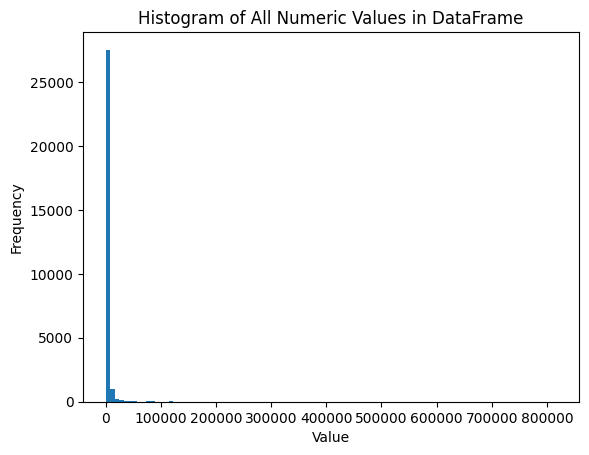

In [16]:
# Plot the histogram
plt.hist(numeric_values, bins=100) #1000 without variance filtering
plt.title("Histogram of All Numeric Values in DataFrame")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [17]:
# Min-Max scale the data
scaler = MinMaxScaler()
df = merged_df.drop('Group', axis=1).set_index('Source Name')
merged_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [18]:
merged_scaled.max().max()

np.float64(1.0000000000000009)

In [19]:
## Plot histogram distribution of all numerical values in the merged SCALED data

# Select only numeric columns and flatten them into a single list, ignoring NaN values
numeric_values = merged_scaled.select_dtypes(include='number').values.flatten()
numeric_values = numeric_values[~np.isnan(numeric_values)]  # Remove NaN values


In [20]:
len(numeric_values)

29237

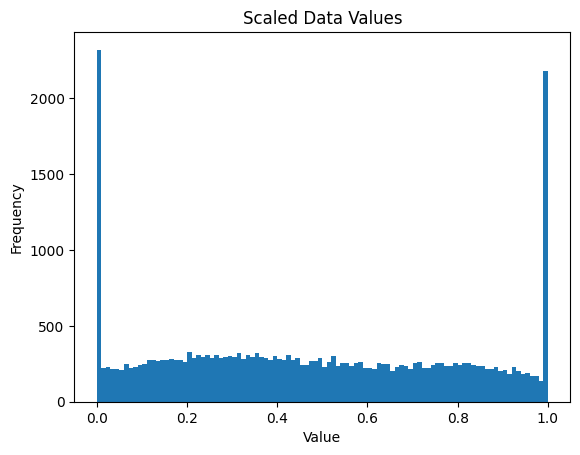

In [21]:
# Plot the histogram
plt.hist(numeric_values, bins=100)
plt.title("Scaled Data Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [22]:
# Add back in the "Group" column

merged_scaled['Group'] = merged_df.set_index('Source Name')["Group"]


## All data all samples

Text(0.5, 1.0, 'Data Types')

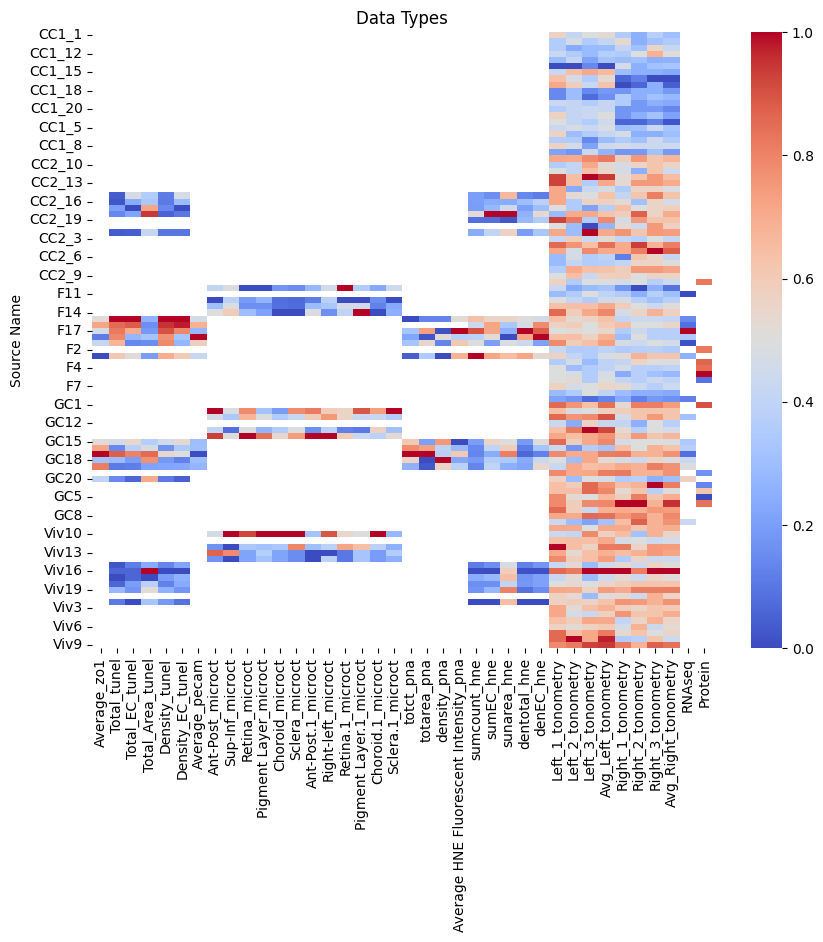

In [23]:
# create heatmap showing which samples have which data types

plt.figure(figsize=(10, 8))
sns.heatmap(merged_scaled[all_phys + [all_genes[0], all_proteins[0]]].rename(columns={all_genes[0]: 'RNAseq', all_proteins[0]: 'Protein'}),
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Data Types")


## Check correlation metrics between Tonometry and RNASeq data on only Complete data
Check this again on imputed data.
Doing only for first few genes for readability of the plot

In [24]:
corr_map = merged_df[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes].dropna().corr().dropna()


In [25]:
corr_map = corr_map.sort_values(by=['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes, ascending=False)

In [26]:
corr_map[['Avg_Left_tonometry', 'Avg_Right_tonometry']].head()

Avg_Left_tonometry  Avg_Right_tonometry
Left_1_tonometry              0.892066             0.308246
Avg_Left_tonometry            1.000000             0.348962
Left_3_tonometry              0.904258             0.255563
Left_2_tonometry              0.913867             0.371178
ENSMUSG00000045983            0.672792             0.666932

In [27]:
threshold = 0.4  # Define your threshold here

# Apply the threshold to the correlation map
filtered_corr_map = corr_map[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                        #    'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                        #    'Avg_Right_tonometry',
                           ]].applymap(lambda x: x if abs(x) > threshold else np.nan)

# filtered_corr_map.dropna(how='all').head()
filtered_corr_map = filtered_corr_map.dropna(how='all', axis=0).dropna(how='all', axis=1)


/var/folders/64/f2__yw2s6dxc5bxsxc_9_0xc0000gn/T/ipykernel_56181/3857675630.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ]].applymap(lambda x: x if abs(x) > threshold else np.nan)


<Axes: >

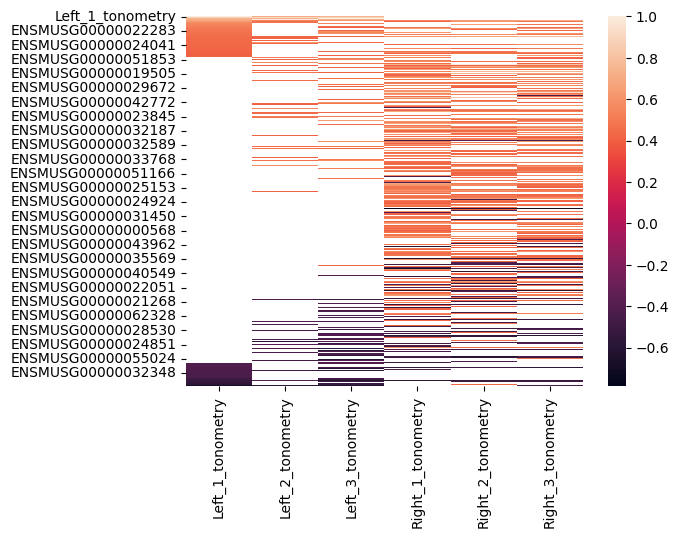

In [28]:
sns.heatmap(filtered_corr_map, linecolor='blue')

In [29]:
# Identify which genes are highly correlated to the top correlated genes from above heatmap
desired_genes_to_check_cluster = merged_df[all_genes].dropna().corr()['ENSMUSG00000024740'].sort_values(ascending=False).head(n=10).index.tolist()
desired_genes_to_check_cluster = desired_genes_to_check_cluster + merged_df[all_genes].dropna().corr()['ENSMUSG00000052613'].sort_values(ascending=False).head(n=10).index.tolist()
desired_genes_to_check_cluster = list(set(desired_genes_to_check_cluster))

In [30]:
desired_genes_to_check_cluster + merged_df[all_genes].dropna().corr()['ENSMUSG00000052613'].sort_values(ascending=False).head(n=10).index.tolist()

['ENSMUSG00000003810',
 'ENSMUSG00000045983',
 'ENSMUSG00000054580',
 'ENSMUSG00000024740',
 'ENSMUSG00000028397',
 'ENSMUSG00000116358',
 'ENSMUSG00000036854',
 'ENSMUSG00000052613',
 'ENSMUSG00000042772',
 'ENSMUSG00000039194',
 'ENSMUSG00000044375',
 'ENSMUSG00000077450',
 'ENSMUSG00000006204',
 'ENSMUSG00000030064',
 'ENSMUSG00000097328',
 'ENSMUSG00000022994',
 'ENSMUSG00000040407',
 'ENSMUSG00000022108',
 'ENSMUSG00000021134',
 'ENSMUSG00000052613',
 'ENSMUSG00000006204',
 'ENSMUSG00000054580',
 'ENSMUSG00000003810',
 'ENSMUSG00000022994',
 'ENSMUSG00000030064',
 'ENSMUSG00000028397',
 'ENSMUSG00000044375',
 'ENSMUSG00000040407',
 'ENSMUSG00000045983']

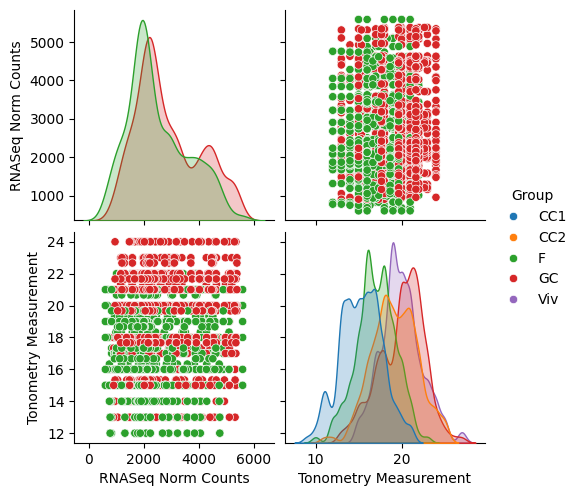

In [31]:
melt_1_df = pd.melt(merged_df[['Source Name', 'Group', 'Left_1_tonometry', 'Left_2_tonometry', 'Left_3_tonometry',
       'Avg_Left_tonometry', 'Right_1_tonometry', 'Right_2_tonometry',
       'Right_3_tonometry', 'Avg_Right_tonometry']+desired_genes_to_check_cluster],
       id_vars=['Source Name', 'Group','Left_1_tonometry', 'Left_2_tonometry', 'Left_3_tonometry',
       'Avg_Left_tonometry', 'Right_1_tonometry', 'Right_2_tonometry',
       'Right_3_tonometry', 'Avg_Right_tonometry'],
       var_name='Gene Name',
       value_name='RNASeq Norm Counts')
melted_df = pd.melt(melt_1_df, id_vars = ['Source Name', 'Group', 'Gene Name', 'RNASeq Norm Counts'],
        var_name='Tonometry Location Rep',
        value_name='Tonometry Measurement')
sns.pairplot(melted_df, hue='Group')

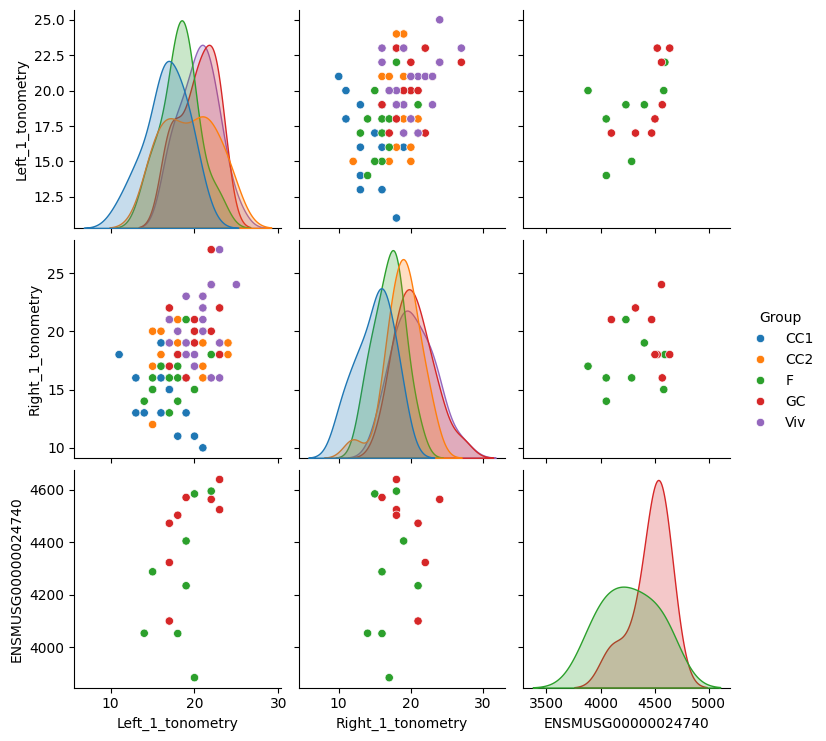

In [32]:
# Choose the gene have the highest set of correlations with the tonometry data to check up on the clustering
sns.pairplot(merged_df[['Source Name', 'Group', 'Left_1_tonometry','Right_1_tonometry',
       'ENSMUSG00000024740']], hue='Group')

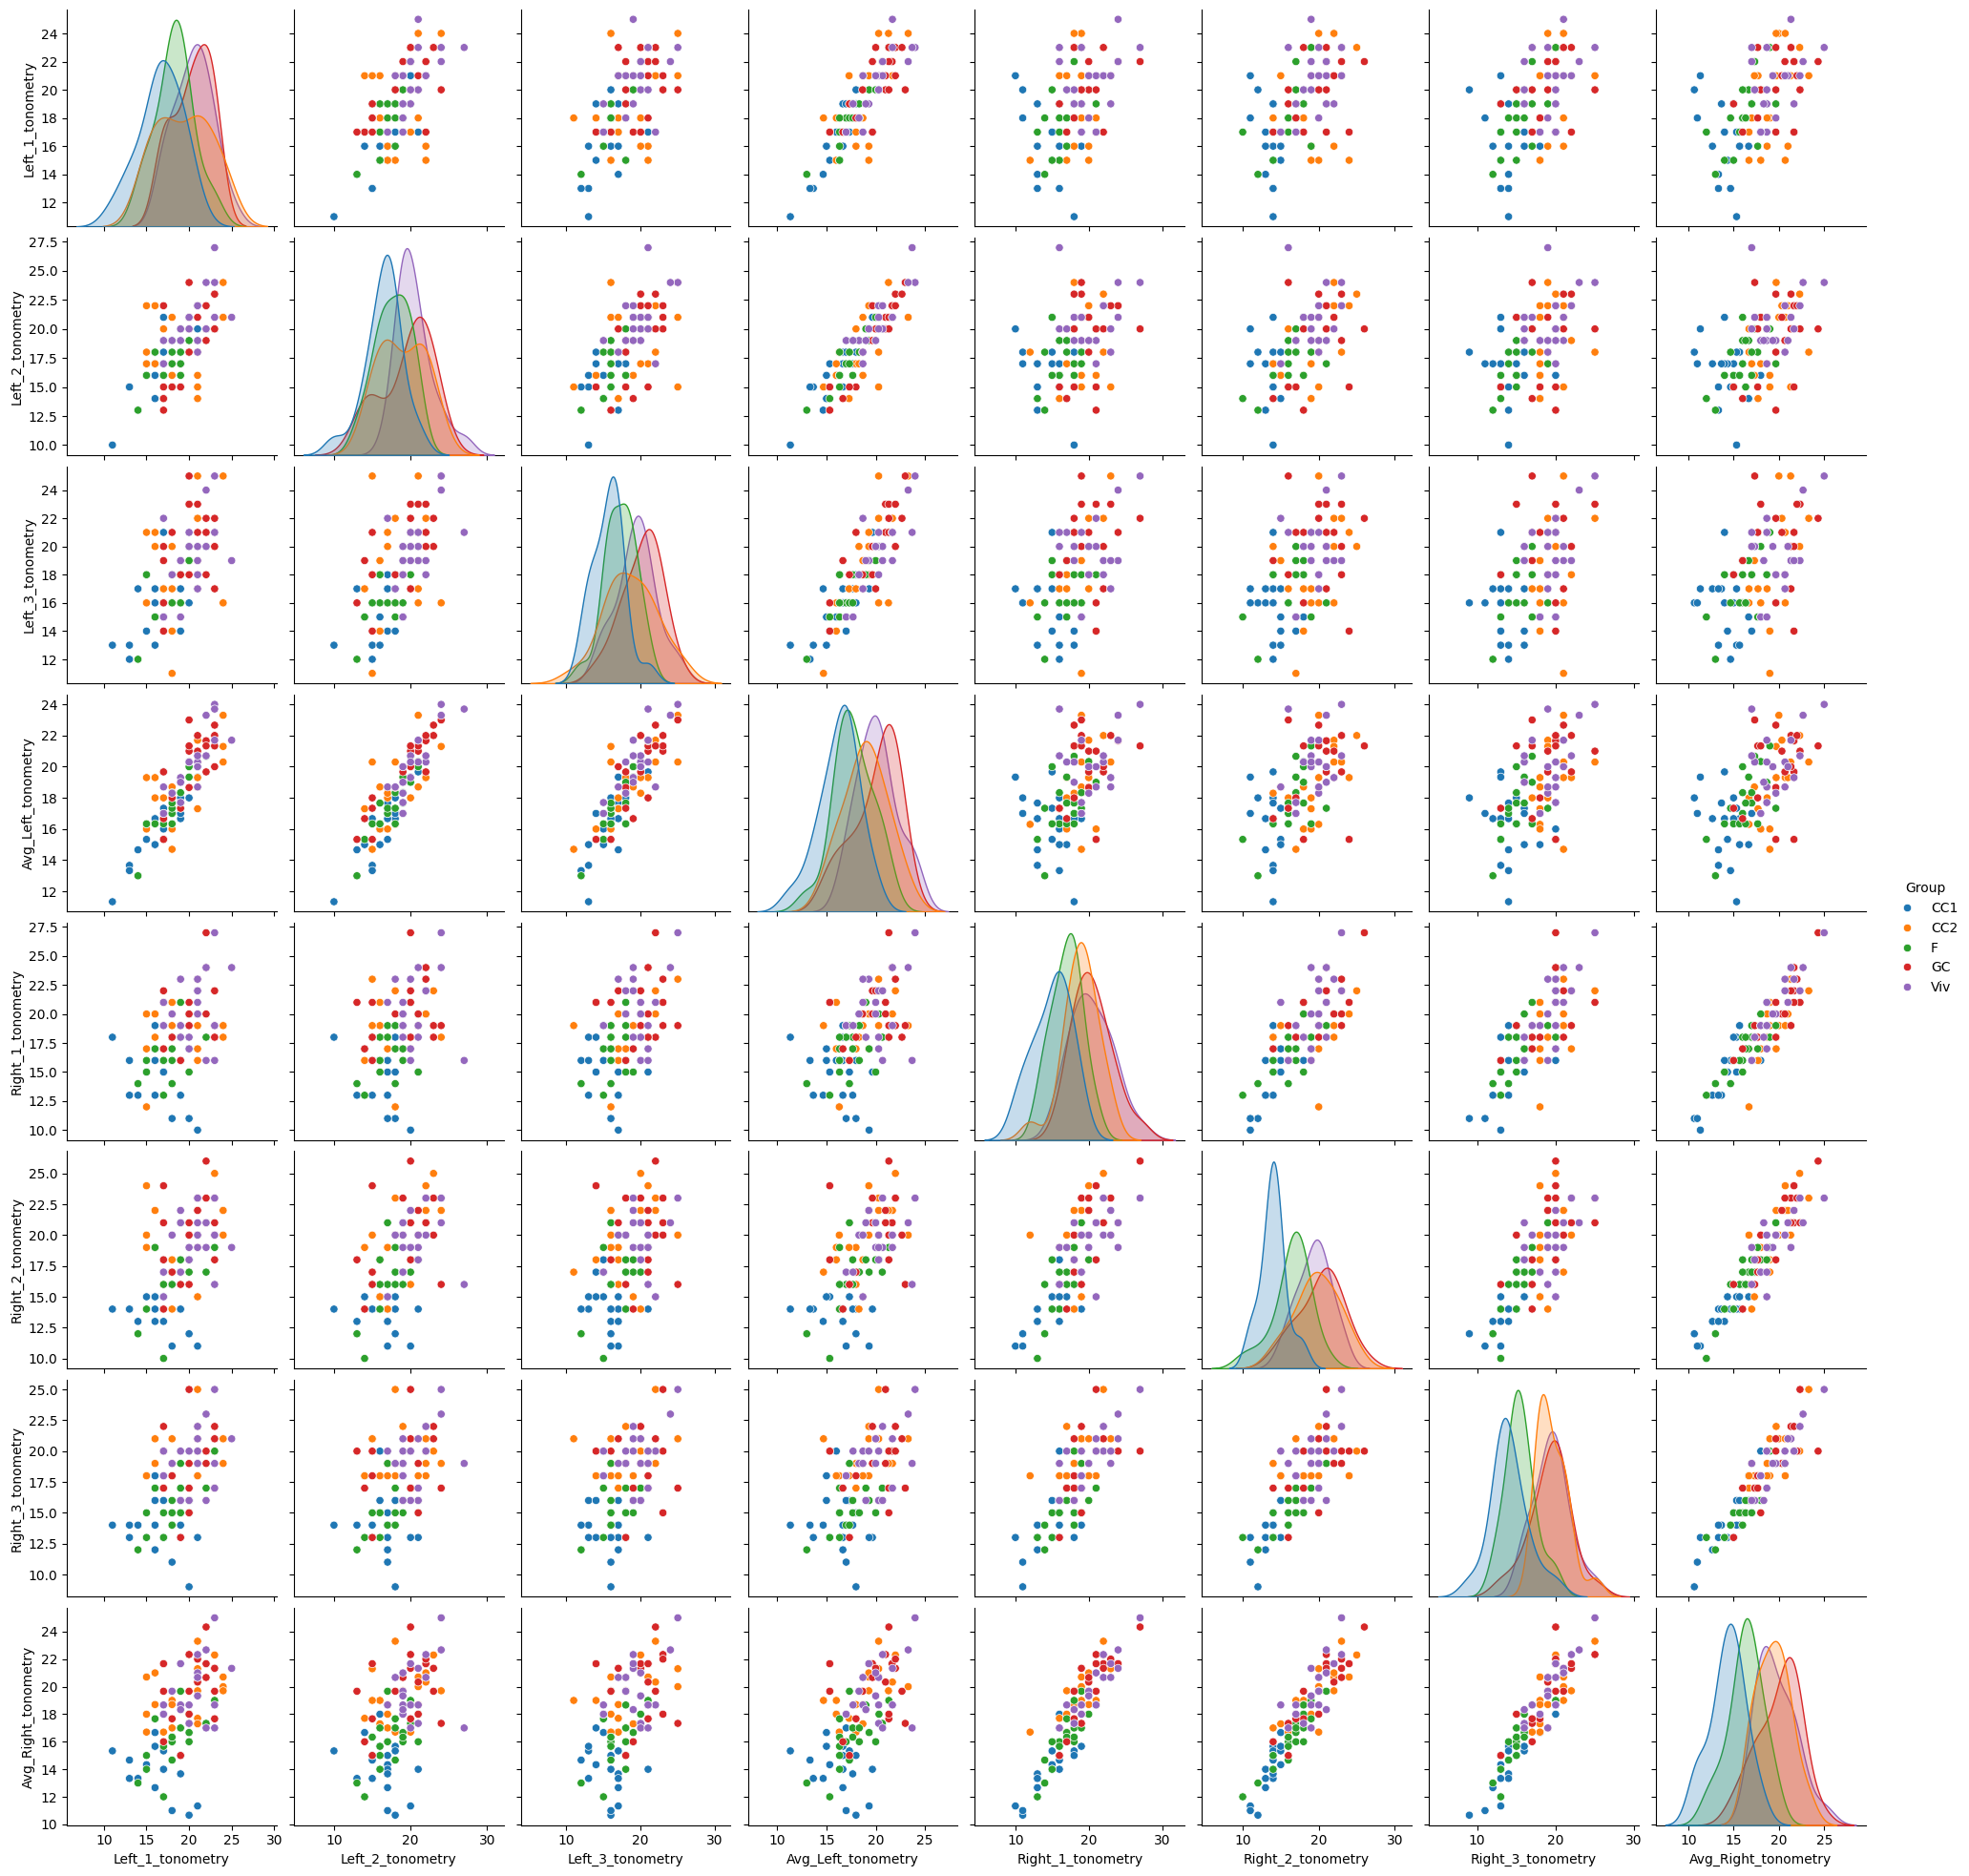

In [33]:
## Tonometry data EDA
tonometrydf = merged_df[['Source Name', 'Group', 'Left_1_tonometry', 'Left_2_tonometry', 'Left_3_tonometry',
       'Avg_Left_tonometry', 'Right_1_tonometry', 'Right_2_tonometry',
       'Right_3_tonometry', 'Avg_Right_tonometry']]
tonometrydf.Group.unique()
# tonometrydf[['Source Name', 'Group', 'Left_1_tonometry', 'Left_2_tonometry']].plot(kind='scatter', x='Left_2_tonometry', y='Left_1_tonometry')
sns.pairplot(data=tonometrydf, hue='Group', )



[4 4 4 1 0 0 4 0 0 0 0 0 0 4 0 4 4 4 4 0 2 1 4 2 2 1 1 4 1 2 2 1 2 4 2 2 4
 1 2 1 4 0 4 4 3 3 3 1 4 3 3 4 1 1 4 4 4 4 0 0 2 1 2 4 3 2 3 1 2 4 2 2 4 2
 3 2 2 2 2 1 2 1 3 2 2 3 1 2 1 1 2 1 2 3 1 3 3 3 3 2]


/var/folders/64/f2__yw2s6dxc5bxsxc_9_0xc0000gn/T/ipykernel_56181/1634354163.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tonometrydf['cluster']=kmeans.labels_


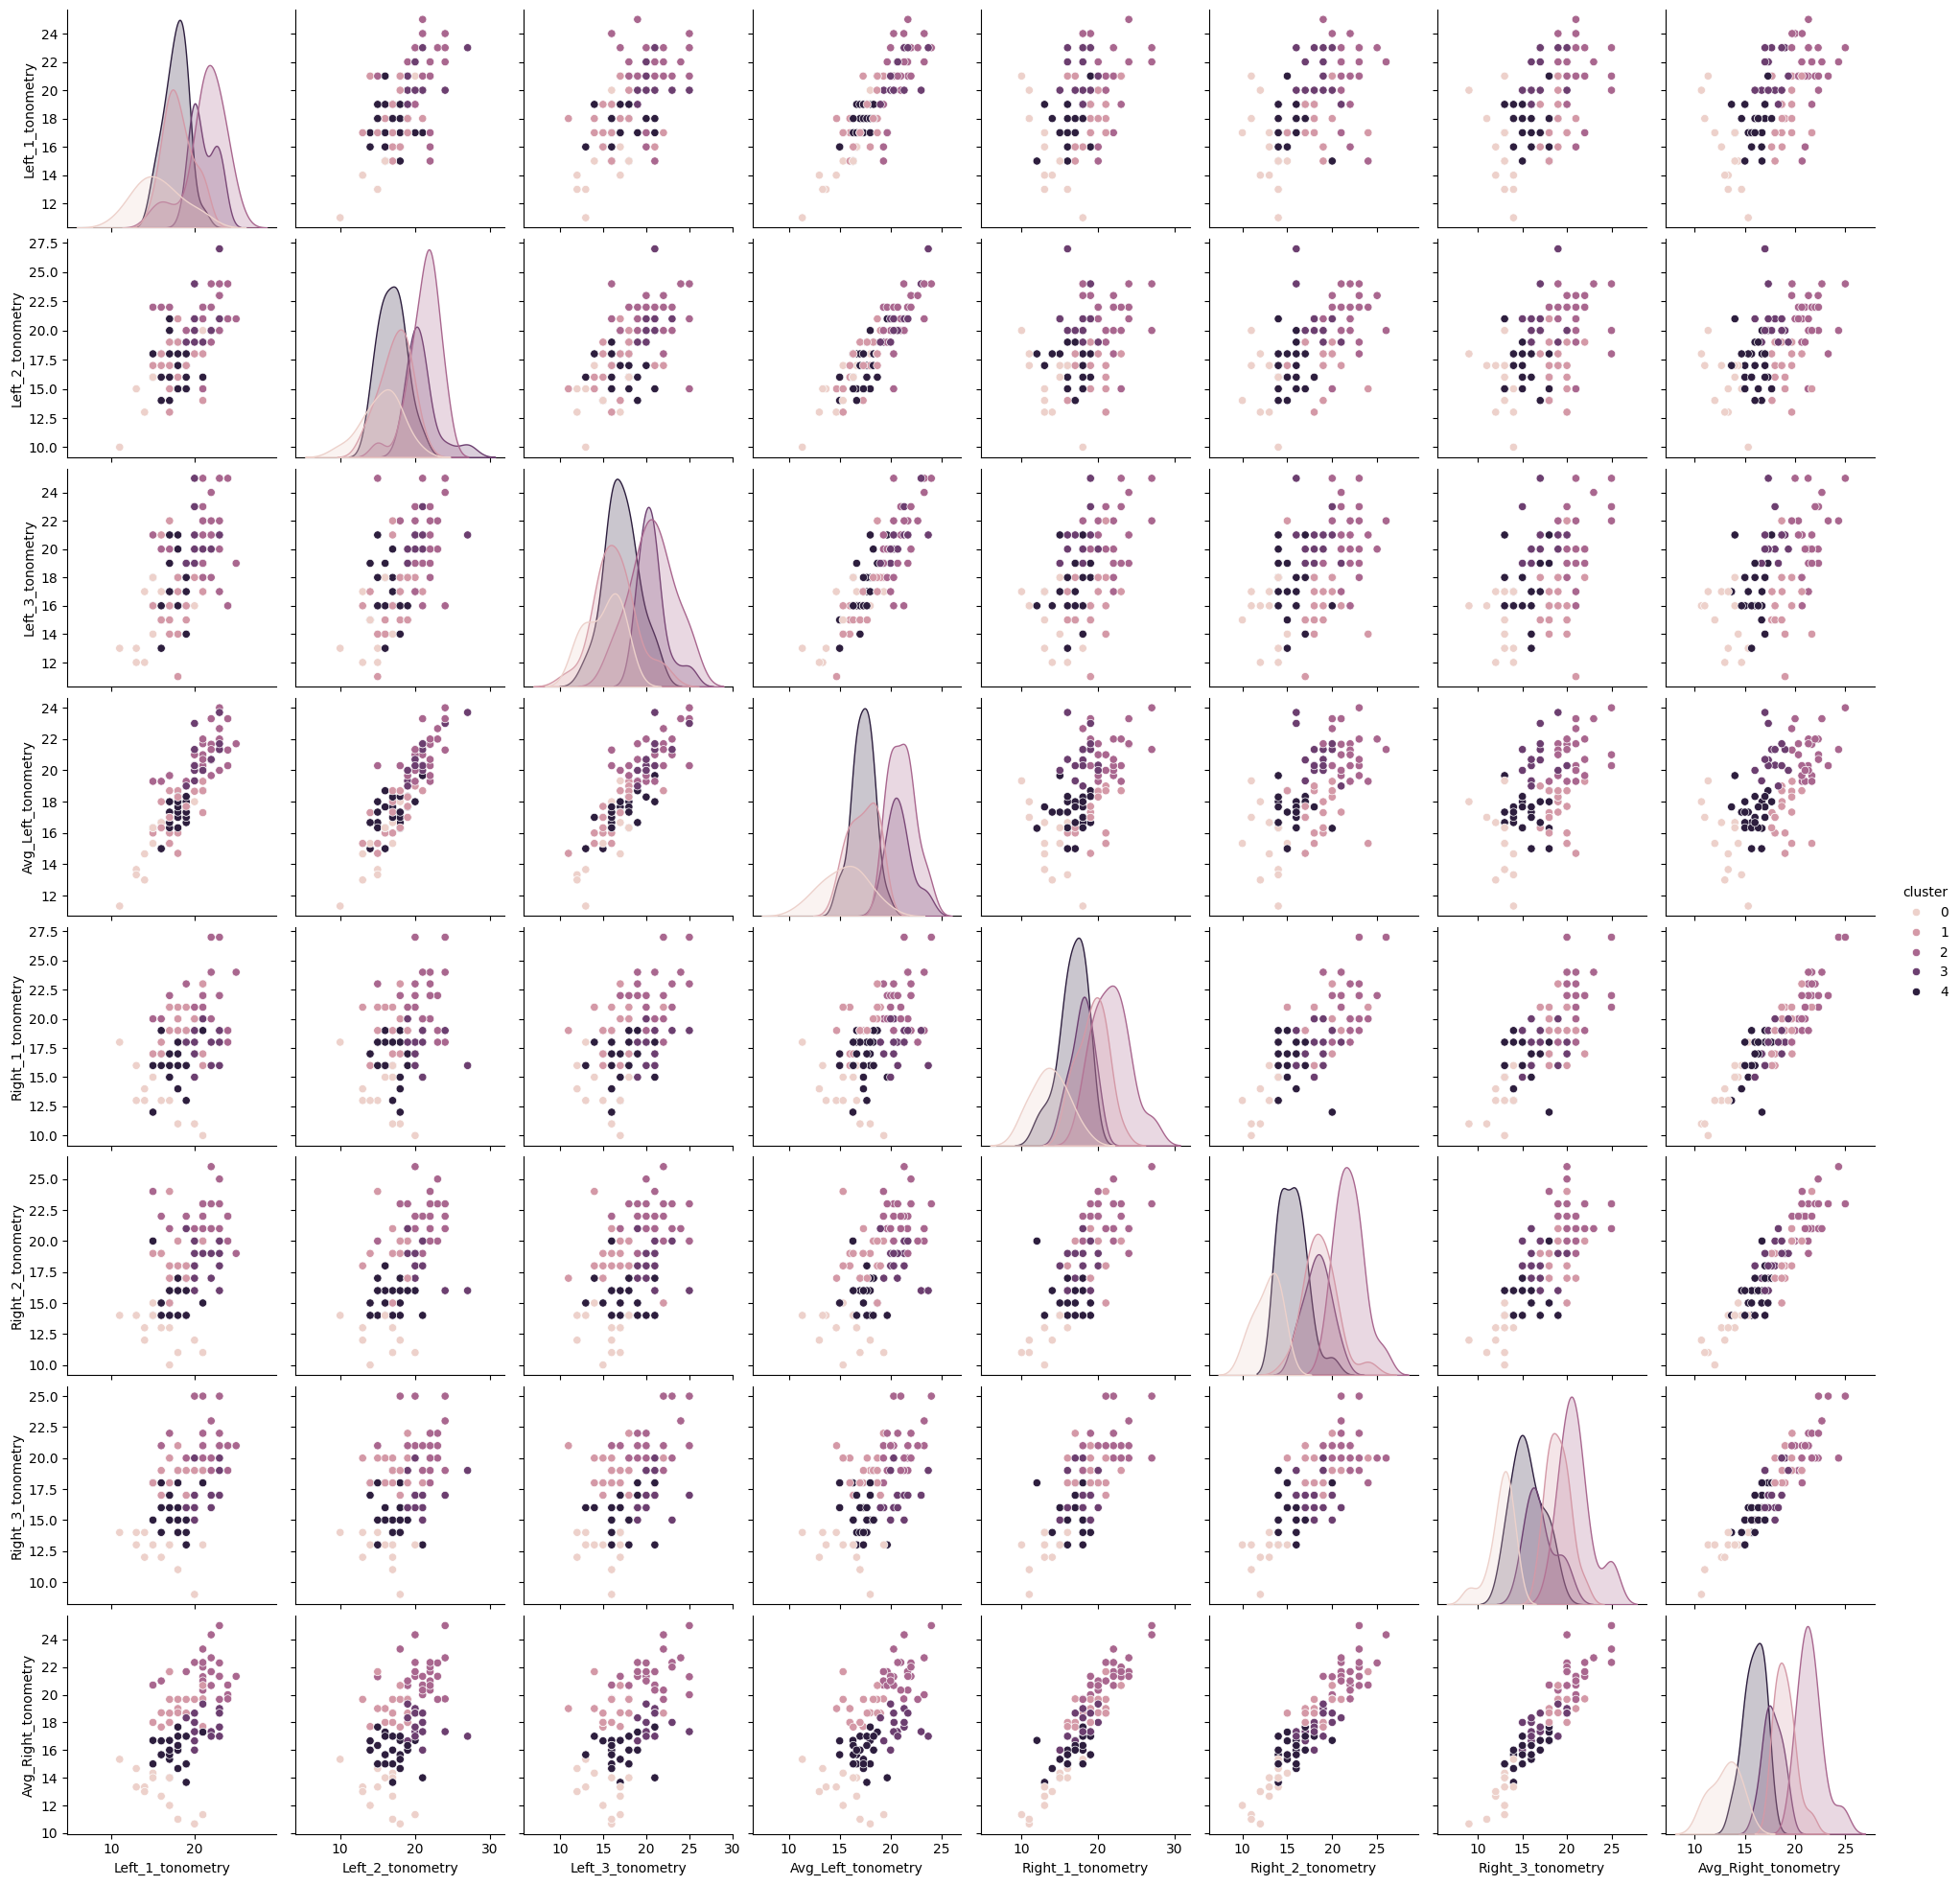

In [34]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
# # Calculate seeds from k-means++
kmeans = KMeans(n_clusters=5, random_state=1, max_iter=300)
kmeans.fit(tonometrydf[['Left_1_tonometry', 'Left_2_tonometry', 'Left_3_tonometry',
       'Right_1_tonometry', 'Right_2_tonometry',
       'Right_3_tonometry',]])
print(kmeans.labels_)
tonometrydf['cluster']=kmeans.labels_
tonometrydf.groupby(['Group', 'cluster']).Left_1_tonometry.count()
sns.pairplot(data=tonometrydf, hue='cluster')

In [35]:
# try with MeanShift Clustering
from sklearn.cluster import MeanShift, estimate_bandwidth
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(tonometrydf[['Left_1_tonometry', 'Left_2_tonometry', 'Left_3_tonometry',
       'Right_1_tonometry', 'Right_2_tonometry',
       'Right_3_tonometry',]], quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(tonometrydf[['Left_1_tonometry', 'Left_2_tonometry', 'Left_3_tonometry',
       'Right_1_tonometry', 'Right_2_tonometry',
       'Right_3_tonometry',]])
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)
tonometrydf['cluster']=ms.labels_
tonometrydf.groupby(['Group', 'cluster']).Left_1_tonometry.count()

number of estimated clusters : 2


/var/folders/64/f2__yw2s6dxc5bxsxc_9_0xc0000gn/T/ipykernel_56181/1230313647.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tonometrydf['cluster']=ms.labels_


Group  cluster
CC1    0          20
CC2    0          17
       1           3
F      0          20
GC     0          15
       1           5
Viv    0          18
       1           2
Name: Left_1_tonometry, dtype: int64

<Axes: xlabel='Avg_Left_tonometry', ylabel='Avg_Right_tonometry'>

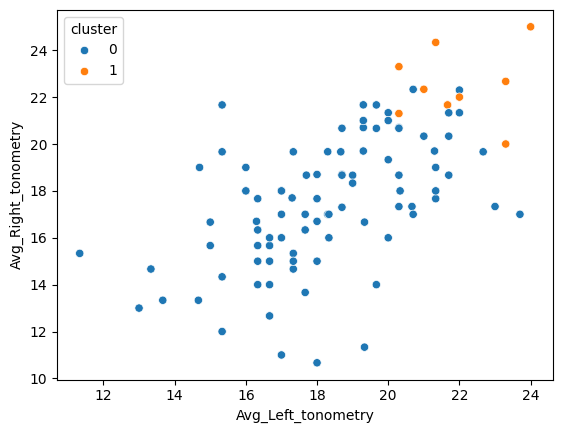

In [36]:
sns.scatterplot(x=tonometrydf['Avg_Left_tonometry'], y=tonometrydf['Avg_Right_tonometry'], data=tonometrydf,hue='cluster')

## Impute missing values

Since not all measurements are available for all animals, impute the missing values based on the available values.

NOTE - this is not necessarily the only thing to do. Feel free to try different approaches.

Approach:

Using Tonometry data alone to impute RNASeq data. Once satisfied with RNASeq imputation, then we move to imputing all other physiological data again from tonometry data alone.

Avoiding imputation from imputed data.

Imputation on raw data and not scaled data as part of standard practices - scaling can distort the relationships between variables and potentially lead to biased imputation results, especially when using methods that rely on distance calculations like KNN imputation; by imputing on the original scale, you preserve the true relationships between variables and ensure that the imputed values are more representative of the original data distribution.

In [37]:
## Imputing RNAseq values based on correlations from Telometry data
## Identifying how much data is absent in RNAseq data
print(merged_df[all_genes].shape)
print(merged_df[all_genes].isna().sum().sum())
# 84000 missing values out of 100,000 values

(100, 1000)
84000


### Iterative Imputer

This is one option for imputing values. Code is below but commented out for now. The imputed values looked very similar across all samples.

https://scikit-learn.org/1.5/modules/generated/sklearn.impute.IterativeImputer.html




***A few params to adjust for compute/memory constraints:

n_nearest_features (int, default=None)
Number of other features to use to estimate the missing values of each feature column. Nearness between features is measured using the absolute correlation coefficient between each feature pair (after initial imputation). To ensure coverage of features throughout the imputation process, the neighbor features are not necessarily nearest, but are drawn with probability proportional to correlation for each imputed target feature. Can provide significant speed-up when the number of features is huge. If None, all features will be used.
*Finishes with 15; crashes with 100.

max_iter (int, default=10)
Maximum number of imputation rounds to perform before returning the imputations computed during the final round. A round is a single imputation of each feature with missing values. The stopping criterion is met once max(abs(X_t - X_{t-1}))/max(abs(X[known_vals])) < tol, where X_t is X at iteration t. Note that early stopping is only applied if sample_posterior=False.

skip_complete (bool, default=False)
If True then features with missing values during transform which did not have any missing values during fit will be imputed with the initial imputation method only. Set to True if you have many features with no missing values at both fit and transform time to save compute.



### Validation Approaches with Imputation Alone
* Grid Search is used to tune hyper parameters, however it doesn't work with imputer yet since we dont have an estimator established.
Few ways to validate the imputer:

1. Visually (show below)
2. Distribution tests
3. Testing the imputer against full data and checking on MAE.

### Iterative Imputer

In [38]:
corr_df = imp_df[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes].dropna().corr().head()
corr_df[corr_df>0.5].dropna(how='all')

NameError: name 'imp_df' is not defined

In [ ]:
## Plot heatmap of correlations between RNAseq data and Tonometry data after imputation

fig = px.imshow(imp_df[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes[0:3]].dropna().corr(),  text_auto=True)
fig.show()

### KNN Imputer

Another option for imputing values. Currently using this option.

https://scikit-learn.org/1.5/modules/generated/sklearn.impute.KNNImputer.html

Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

**Fewer neighbors are better (~2)**

In [30]:
from sklearn.impute import KNNImputer

imp_knn5 = KNNImputer(n_neighbors=5, weights='distance')
imp_df_knn5 = imp_knn5.fit_transform(merged_df[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes])
imp_df_knn5 = pd.DataFrame(imp_df_knn5, columns=['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes)
imp_df_knn5['Source Name'] = merged_df['Source Name']
imp_df_knn5['Group'] = merged_df['Group']

imp_knn = KNNImputer(n_neighbors=2, weights='distance')
imp_df_knn = imp_knn.fit_transform(merged_df[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes])
imp_df_knn = pd.DataFrame(imp_df_knn, columns=['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes)
imp_df_knn['Source Name'] = merged_df['Source Name']
imp_df_knn['Group'] = merged_df['Group']

In [ ]:
fig = px.imshow(imp_df_knn5[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes[0:3]].dropna().corr(),  text_auto=True)
fig.show()

In [ ]:
fig = px.imshow(imp_df_knn[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes[0:3]].dropna().corr(),  text_auto=True)
fig.show()

### Random Sample Imputer
This is used in cases where there is more than 25-30% of data to be imputed and is also fast compared to others.

In [33]:
rsi = RandomSampleImputer()
imp_df_rsi = rsi.fit_transform(merged_df[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes])
imp_df_rsi = pd.DataFrame(imp_df_rsi, columns=['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes)
imp_df_rsi['Source Name'] = merged_df['Source Name']
imp_df_rsi['Group'] = merged_df['Group']

In [ ]:
fig = px.imshow(imp_df_rsi[['Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes[0:3]].dropna().corr(),  text_auto=True)
fig.show()

### Visual Validation of the Imputers

In [ ]:
# Extract RNAseq data from original data
rnaseq_original = merged_df[all_genes+['Source Name', 'Group']].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_itera_imp = imp_df[all_genes+['Source Name', 'Group']].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_knn_imp = imp_df_knn[all_genes+['Source Name', 'Group']].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_knn5_imp = imp_df_knn5[all_genes+['Source Name', 'Group']].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_rsi_imp = imp_df_rsi[all_genes+['Source Name', 'Group']].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
# Select first five gene to plot
gene_to_plot = random.sample(all_genes, 5)
for gene in gene_to_plot:
    # Filter the data for the selected gene
    original_gene_data = rnaseq_original[rnaseq_original['Gene'] == gene]
    itera_imp_gene_data = rnaseq_itera_imp[rnaseq_itera_imp['Gene'] == gene]
    knn_imp_gene_data = rnaseq_knn_imp[rnaseq_knn_imp['Gene'] == gene]
    knn10_imp_gene_data = rnaseq_knn5_imp[rnaseq_knn5_imp['Gene'] == gene]
    rsi_imp_gene_data = rnaseq_rsi_imp[rnaseq_rsi_imp['Gene'] == gene]
    # Plot the data
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=original_gene_data, x='Source Name', y='Expression', marker='o', label='Original')
    sns.lineplot(data=itera_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='--', label='Iterative Imputed')
    sns.lineplot(data=knn_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='dashdot', label='KNN Imputed with 2 Neigbors')
    sns.lineplot(data=knn10_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='dashdot', label='KNN Imputed with 5 Neigbors')
    sns.lineplot(data=rsi_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='-.', label='Random Sample Imputed')
    plt.title(f'Expression of {gene} Across All Samples')
    plt.xlabel('Source Name')
    plt.ylabel('Expression')
    plt.xticks(rotation=90)
    plt.legend(title='Impute Method')
    plt.show()

### MICE - Multivariate Imputation with Chain Equation
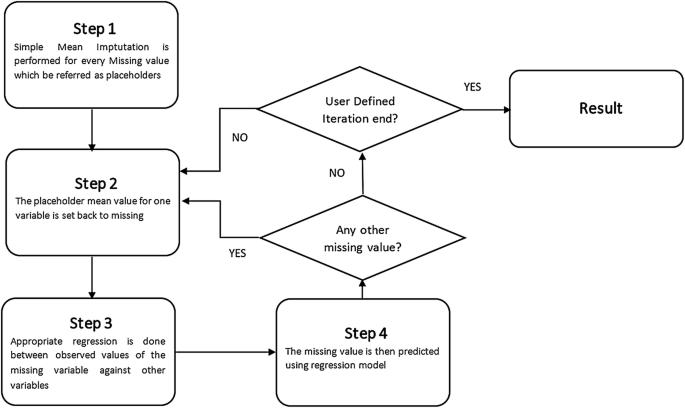
One can impute missing values by predicting them using other features from the dataset.

The MICE or ‘Multiple Imputations by Chained Equations’, aka, ‘Fully Conditional Specification’ is a popular approach to do this. 

Here is a quick intuition (not the exact algorithm)

1. You basically take the variable that contains missing values as a response ‘Y’ and other variables as predictors ‘X’.

2. Build a model with rows where Y is not missing.

3. Then predict the missing observations.

Do this multiple times by doing random draws of the data and taking the mean of the predictions.

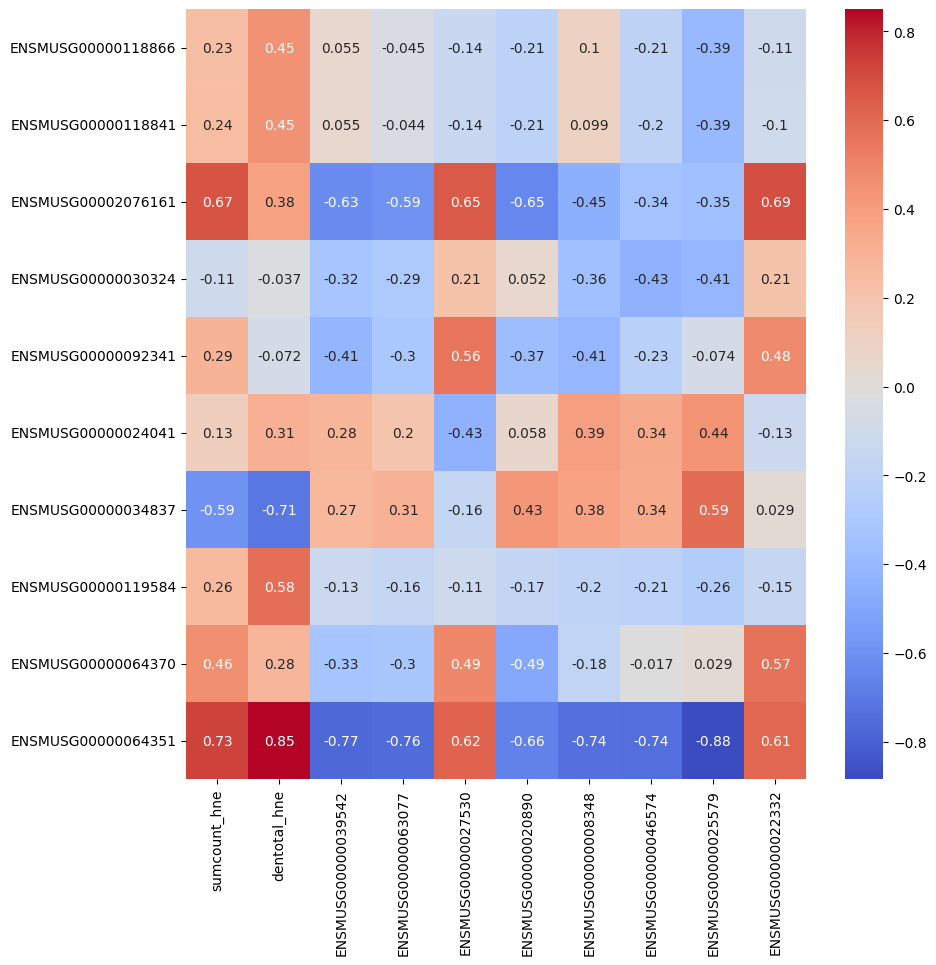

In [39]:
corr_matrix = merged_scaled.drop(columns='Group').corr()

# for col in corr_matrix:
#     corr_matrix[col] = corr_matrix[col].sort_values(ascending=False, ignore_index=True)
corr_col_list = corr_matrix[abs(corr_matrix)>0.5].dropna(axis=1, how='all').isna().sum().sort_values().index[0:10]

subset = corr_matrix[corr_col_list].head(10)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(subset, annot=True, cmap='coolwarm', ax=ax)
plt.show()

In [40]:
corr_orig = corr_matrix.unstack().reset_index()
corr_orig.rename(columns={'level_0': 'para_1', 'level_1':'para_2',
                          0:'corr_coef_orig'}, inplace=True)
corr_orig.head()

para_1              para_2  corr_coef_orig
0  ENSMUSG00000118866  ENSMUSG00000118866        1.000000
1  ENSMUSG00000118866  ENSMUSG00000118841        0.999729
2  ENSMUSG00000118866  ENSMUSG00002076161       -0.036167
3  ENSMUSG00000118866  ENSMUSG00000030324       -0.311575
4  ENSMUSG00000118866  ENSMUSG00000092341       -0.447993

In [41]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
to_impute_df = merged_scaled.reset_index().copy()
lgbr = HistGradientBoostingRegressor(random_state=2)
itera_imp = IterativeImputer(random_state=2, initial_strategy='median', estimator=lgbr, max_iter=10, verbose=2)
itera_imp.fit(to_impute_df.drop(columns=['Source Name', 'Group']))


[IterativeImputer] Completing matrix with shape (100, 2036)
[IterativeImputer] Ending imputation round 1/10, elapsed time 176.53
[IterativeImputer] Change: 131.86567455769318, scaled tolerance: 0.0010000000000000009 
[IterativeImputer] Ending imputation round 2/10, elapsed time 344.02
[IterativeImputer] Change: 0.0, scaled tolerance: 0.0010000000000000009 
[IterativeImputer] Early stopping criterion reached.


IterativeImputer(estimator=HistGradientBoostingRegressor(random_state=2),
                 initial_strategy='median', random_state=2, verbose=2)

In [42]:
df_imputed = itera_imp.transform(to_impute_df.drop(columns=['Source Name', 'Group']))

[IterativeImputer] Completing matrix with shape (100, 2036)
[IterativeImputer] Ending imputation round 1/2, elapsed time 7.64
[IterativeImputer] Ending imputation round 2/2, elapsed time 14.69


In [43]:
col_list = to_impute_df.columns.to_list()
col_list.remove('Source Name')
col_list.remove('Group')

In [44]:
to_impute_df.loc[:, col_list] = df_imputed
to_impute_df.head()

Source Name  ENSMUSG00000118866  ENSMUSG00000118841  ENSMUSG00002076161  \
0       CC1_1            0.311998             0.30987            0.179768   
1      CC1_10            0.311998             0.30987            0.179768   
2      CC1_11            0.311998             0.30987            0.179768   
3      CC1_12            0.311998             0.30987            0.179768   
4      CC1_13            0.311998             0.30987            0.179768   

   ENSMUSG00000030324  ENSMUSG00000092341  ENSMUSG00000024041  \
0            0.426185            0.516395            0.081028   
1            0.426185            0.516395            0.081028   
2            0.426185            0.516395            0.081028   
3            0.426185            0.516395            0.081028   
4            0.426185            0.516395            0.081028   

   ENSMUSG00000034837  ENSMUSG00000119584  ENSMUSG00000064370  ...  denEC_hne  \
0            0.547909            0.557493            0.346393  ...   0.373177   
1            0.547909            0.557493            0.346393  ...   0.373177   
2            0.547909            0.557493            0.346393  ...   0.373177   
3            0.547909            0.557493            0.346393  ...   0.373177   
4            0.547909            0.557493            0.346393  ...   0.373177   

   Left_1_tonometry  Left_2_tonometry  Left_3_tonometry  Avg_Left_tonometry  \
0          0.571429          0.411765          0.500000            0.526316   
1          0.357143          0.470588          0.357143            0.421053   
2          0.357143          0.235294          0.285714            0.289474   
3          0.428571          0.352941          0.285714            0.368421   
4          0.285714          0.411765          0.214286            0.315789   

   Right_1_tonometry  Right_2_tonometry  Right_3_tonometry  \
0           0.352941             0.2500             0.3750   
1           0.529412             0.2500             0.3125   
2           0.411765             0.3125             0.5625   
3           0.352941             0.5000             0.6875   
4           0.294118             0.3125             0.2500   

   Avg_Right_tonometry  Group  
0             0.302326    CC1  
1             0.348837    CC1  
2             0.418605    CC1  
3             0.511628    CC1  
4             0.255814    CC1  

[5 rows x 2038 columns]

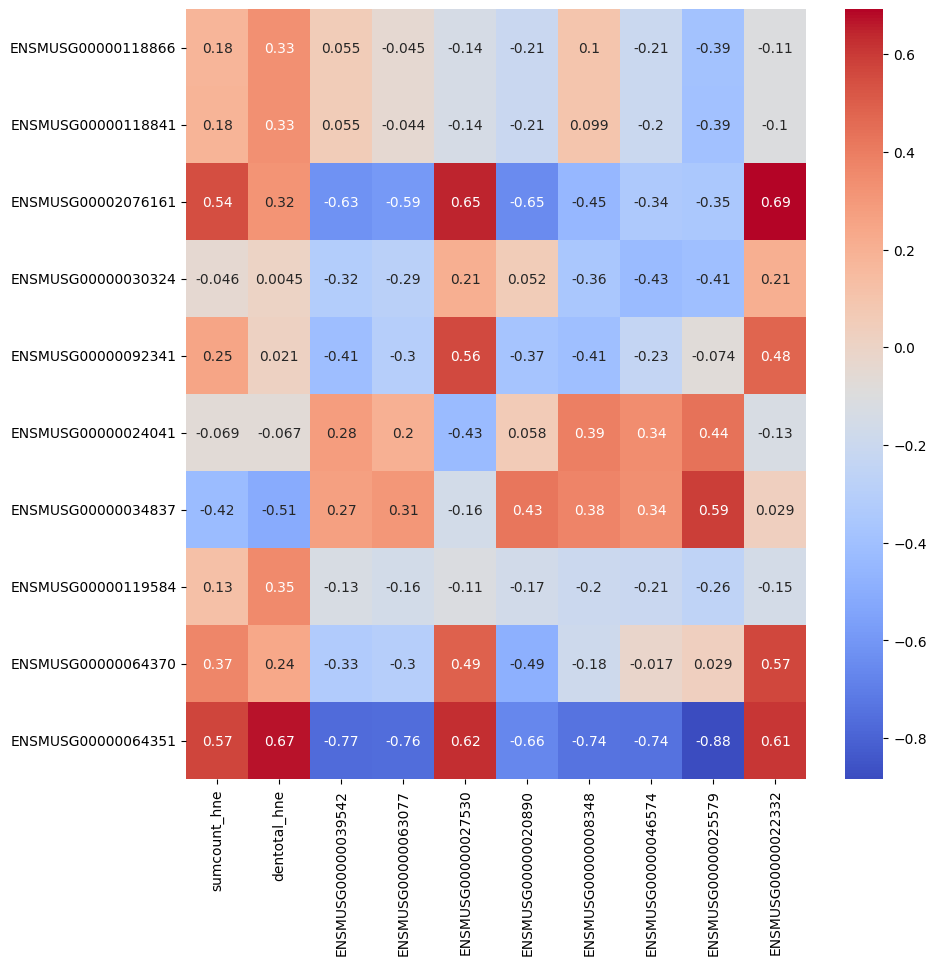

In [45]:
corr_matrix2 = to_impute_df.drop(columns=['Source Name','Group']).corr()

# for col in corr_matrix2:
#     corr_matrix2[col] = corr_matrix2[col].sort_values(ascending=False, ignore_index=True)
# col_list = corr_matrix[abs(corr_matrix)>0.5].dropna(axis=1, how='all').isna().sum().sort_values().index[0:10]

subset2 = corr_matrix2[corr_col_list].head(10) #use the earlier column list to compare apples to apples

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(subset2, annot=True, cmap='coolwarm', ax=ax)
plt.show()

In [46]:
corr_itera_impute_df = corr_matrix2.unstack().reset_index()
corr_itera_impute_df.rename(columns={'level_0': 'para_1', 'level_1':'para_2',
                          0:'corr_coef_iter'}, inplace=True)
corr_itera_impute_df.head()

para_1              para_2  corr_coef_iter
0  ENSMUSG00000118866  ENSMUSG00000118866        1.000000
1  ENSMUSG00000118866  ENSMUSG00000118841        0.999729
2  ENSMUSG00000118866  ENSMUSG00002076161       -0.036167
3  ENSMUSG00000118866  ENSMUSG00000030324       -0.311575
4  ENSMUSG00000118866  ENSMUSG00000092341       -0.447993

## MICE with Bagging Regressor

In [56]:
from sklearn.ensemble import BaggingRegressor
to_impute_df_bagger = merged_scaled.reset_index().copy()
bagger = BaggingRegressor(random_state=2)
itera_bagger = IterativeImputer(random_state=2, initial_strategy='median', estimator=bagger, max_iter=50, verbose=2, tol=130)
itera_bagger.fit(to_impute_df_bagger.drop(columns=['Source Name', 'Group']))


[IterativeImputer] Completing matrix with shape (100, 2036)
[IterativeImputer] Ending imputation round 1/50, elapsed time 26.75
[IterativeImputer] Change: 128.92271685247312, scaled tolerance: 130.0000000000001 
[IterativeImputer] Early stopping criterion reached.


IterativeImputer(estimator=BaggingRegressor(random_state=2),
                 initial_strategy='median', max_iter=50, random_state=2,
                 tol=130, verbose=2)

In [57]:
itera_bagg_df_imputed = itera_bagger.transform(to_impute_df_bagger.drop(columns=['Source Name', 'Group']))
col_list = to_impute_df_bagger.columns.to_list()
col_list.remove('Source Name')
col_list.remove('Group')
to_impute_df_bagger.loc[:, col_list] = itera_bagg_df_imputed
to_impute_df_bagger.head()

[IterativeImputer] Completing matrix with shape (100, 2036)
[IterativeImputer] Ending imputation round 1/1, elapsed time 3.90


Source Name  ENSMUSG00000118866  ENSMUSG00000118841  ENSMUSG00002076161  \
0       CC1_1            0.254825            0.241349            0.121015   
1      CC1_10            0.254825            0.241349            0.121015   
2      CC1_11            0.254825            0.241349            0.121015   
3      CC1_12            0.254825            0.241349            0.121015   
4      CC1_13            0.254825            0.241349            0.121015   

   ENSMUSG00000030324  ENSMUSG00000092341  ENSMUSG00000024041  \
0            0.313937            0.471799            0.003106   
1            0.313937            0.530206            0.003106   
2            0.313937            0.530206            0.003106   
3            0.313937            0.530206            0.003106   
4            0.313937            0.530206            0.003106   

   ENSMUSG00000034837  ENSMUSG00000119584  ENSMUSG00000064370  ...  denEC_hne  \
0             0.50759            0.623347            0.253660  ...   0.321859   
1             0.50759            0.623347            0.236219  ...   0.199463   
2             0.50759            0.623347            0.253660  ...   0.220874   
3             0.50759            0.623347            0.253660  ...   0.220874   
4             0.50759            0.623347            0.253660  ...   0.217775   

   Left_1_tonometry  Left_2_tonometry  Left_3_tonometry  Avg_Left_tonometry  \
0          0.571429          0.411765          0.500000            0.526316   
1          0.357143          0.470588          0.357143            0.421053   
2          0.357143          0.235294          0.285714            0.289474   
3          0.428571          0.352941          0.285714            0.368421   
4          0.285714          0.411765          0.214286            0.315789   

   Right_1_tonometry  Right_2_tonometry  Right_3_tonometry  \
0           0.352941             0.2500             0.3750   
1           0.529412             0.2500             0.3125   
2           0.411765             0.3125             0.5625   
3           0.352941             0.5000             0.6875   
4           0.294118             0.3125             0.2500   

   Avg_Right_tonometry  Group  
0             0.302326    CC1  
1             0.348837    CC1  
2             0.418605    CC1  
3             0.511628    CC1  
4             0.255814    CC1  

[5 rows x 2038 columns]

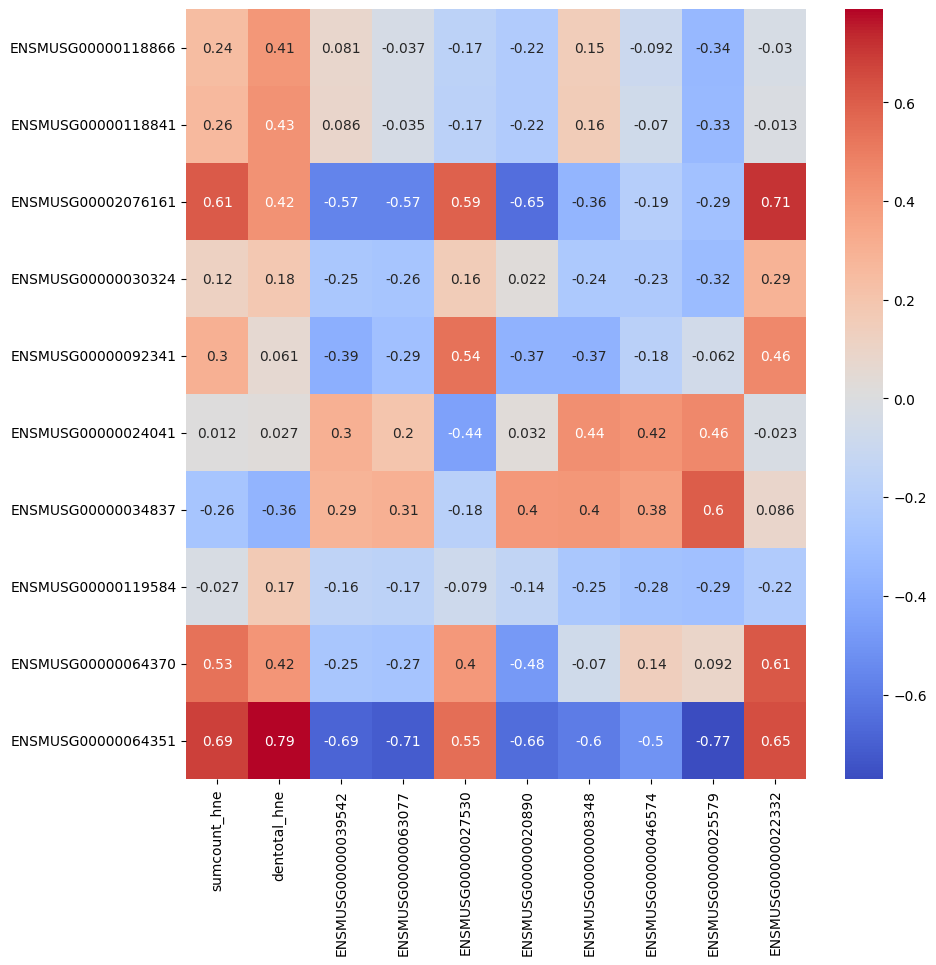

In [58]:
corr_matrix3 = to_impute_df_bagger.drop(columns=['Source Name','Group']).corr()

# for col in corr_matrix2:
#     corr_matrix2[col] = corr_matrix2[col].sort_values(ascending=False, ignore_index=True)
# col_list = corr_matrix[abs(corr_matrix)>0.5].dropna(axis=1, how='all').isna().sum().sort_values().index[0:10]

subset3 = corr_matrix3[corr_col_list].head(10) #use the earlier column list to compare apples to apples

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(subset3, annot=True, cmap='coolwarm', ax=ax)
plt.show()

In [59]:
corr_bag_impute_df = corr_matrix3.unstack().reset_index()
corr_bag_impute_df.rename(columns={'level_0': 'para_1', 'level_1':'para_2',
                          0:'corr_coef_knn'}, inplace=True)
corr_bag_impute_df.head()

para_1              para_2  corr_coef_knn
0  ENSMUSG00000118866  ENSMUSG00000118866       1.000000
1  ENSMUSG00000118866  ENSMUSG00000118841       0.998909
2  ENSMUSG00000118866  ENSMUSG00002076161       0.015200
3  ENSMUSG00000118866  ENSMUSG00000030324      -0.221459
4  ENSMUSG00000118866  ENSMUSG00000092341      -0.415802

## Check all the corr maps together

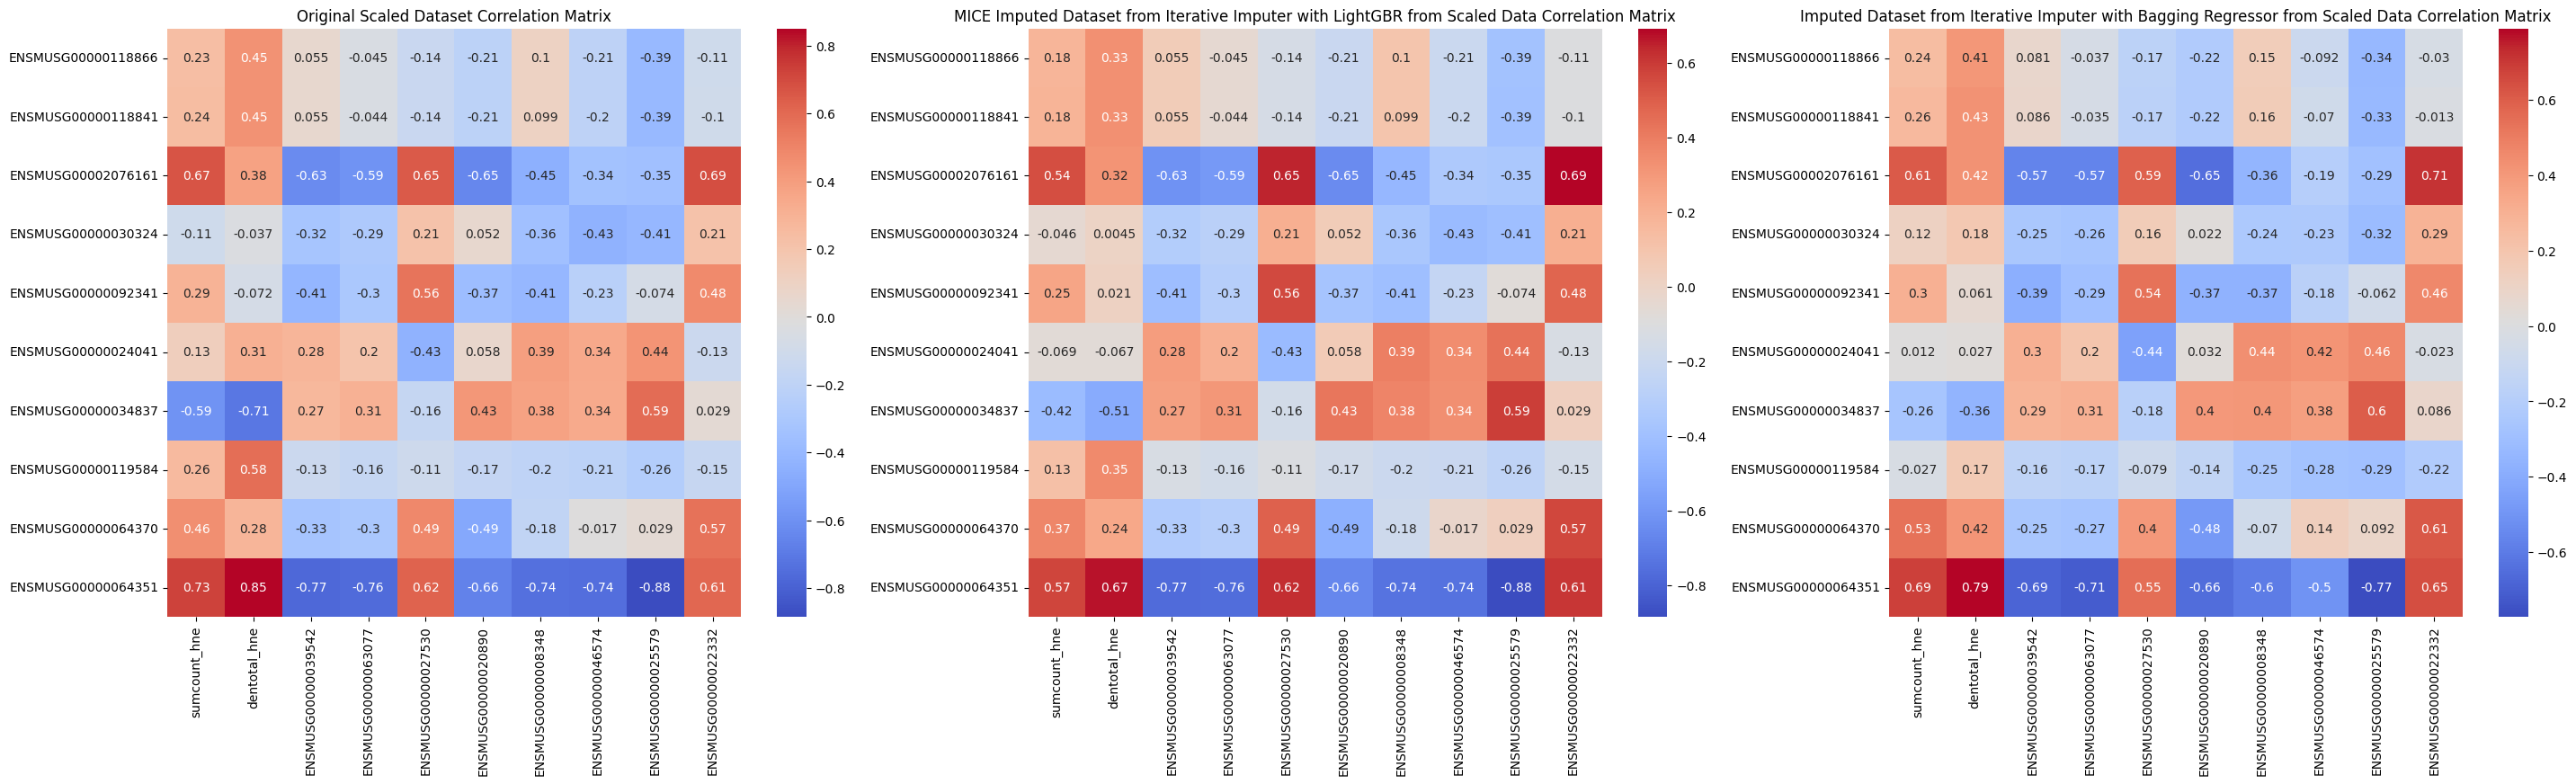

In [61]:
#put the two corr matrices side by side for ease of comparison
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(35, 8.5))
sns.heatmap(subset, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title("Original Scaled Dataset Correlation Matrix")
sns.heatmap(subset2, annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title("MICE Imputed Dataset from Iterative Imputer with LightGBR from Scaled Data Correlation Matrix")
sns.heatmap(subset3, annot=True, cmap='coolwarm', ax=ax[2])
ax[2].set_title("Imputed Dataset from Iterative Imputer with Bagging Regressor from Scaled Data Correlation Matrix")

plt.show()

In [78]:
corr_orig.head() #merge_scaled correlation as unstacked table
corr_itera_impute_df.head() #iterative imputer correlation unstacked table
corr_knn_impute_df.head() #KNNImputer correlation as unstacked

merge_1 = pd.merge(corr_orig, corr_itera_impute_df, how='inner').dropna()
corr_comparison_df = pd.merge(merge_1,corr_knn_impute_df, how='inner').dropna()
corr_comparison_df.head()
corr_comparison_df = corr_comparison_df[corr_comparison_df['para_1']!=corr_comparison_df['para_2']].reset_index(drop=True)

In [79]:
import scipy.stats as stats
print(stats.spearmanr(corr_comparison_df['corr_coef_knn'], corr_comparison_df['corr_coef_orig']))

print(stats.spearmanr(corr_comparison_df['corr_coef_iter'], corr_comparison_df['corr_coef_orig']))

print(stats.spearmanr(corr_comparison_df['corr_coef_knn'], corr_comparison_df['corr_coef_iter']))

SignificanceResult(statistic=np.float64(0.9169628732407), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9964142903457162), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.9155631560035328), pvalue=np.float64(0.0))


<Axes: xlabel='corr_coef_iter', ylabel='corr_coef_knn'>

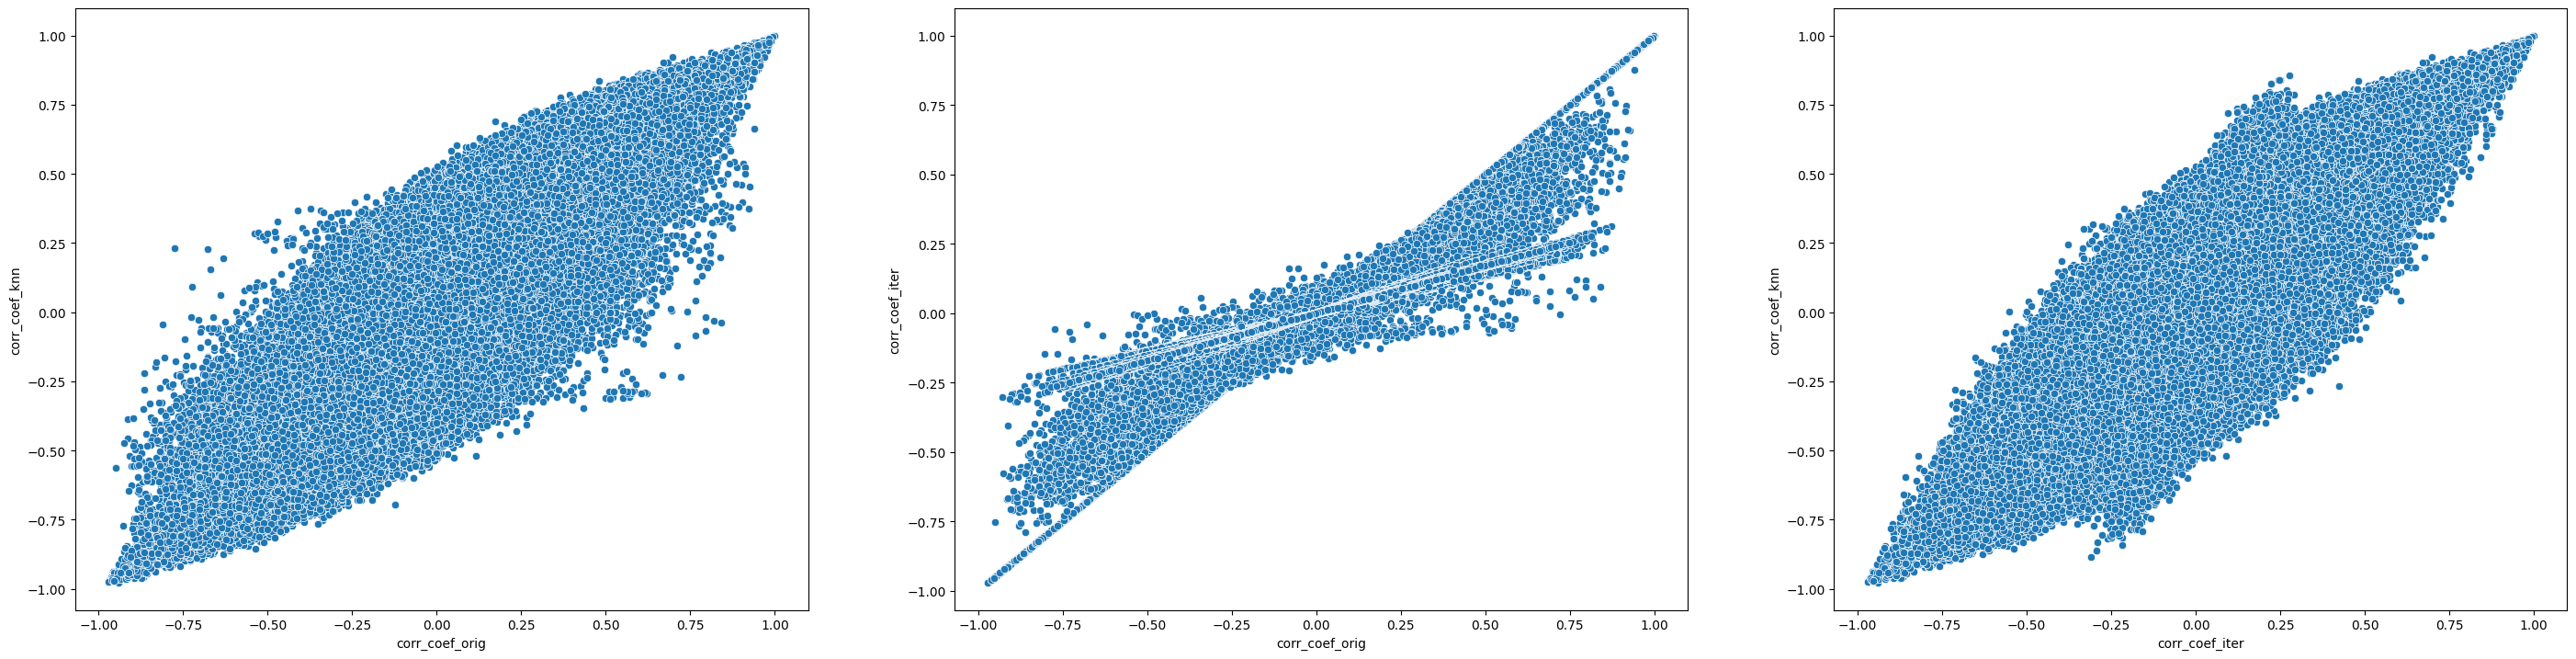

In [82]:
fig,ax = plt.subplots(1,3, figsize=(35, 8.5))
sns.scatterplot(x = corr_comparison_df['corr_coef_orig'], y = corr_comparison_df['corr_coef_knn'],
                data=corr_comparison_df, ax=ax[0])
sns.scatterplot(x = corr_comparison_df['corr_coef_orig'], y = corr_comparison_df['corr_coef_iter'],
                data=corr_comparison_df, ax=ax[1])
sns.scatterplot(x = corr_comparison_df['corr_coef_iter'], y = corr_comparison_df['corr_coef_knn'],
                data=corr_comparison_df, ax=ax[2])

In [88]:
(merged_scaled.isna().sum() * 100 / len(merged_scaled)).sort_values(ascending=False)

Average HNE Fluorescent Intensity_pna    90.0
density_pna                              90.0
totarea_pna                              90.0
totct_pna                                90.0
Average_pecam                            89.0
O88990                                   88.0
Q8BT35                                   88.0
A0A0A0MQ69                               88.0
Q9D258                                   88.0
Q3V4A1                                   88.0
Q9D168                                   88.0
Q0VGN5                                   88.0
Q9JJQ6                                   88.0
P50543                                   88.0
Q8BJ03                                   88.0
Q3U9G9                                   88.0
Q545H7                                   88.0
Q9DBS8                                   88.0
Q5NCR9                                   88.0
G3UZY2                                   88.0
Q8CJ61                                   88.0
Q8K1J5                            

### MAE/MSE check with the Complete data

In [76]:
X = merged_df[['Source Name','Group','Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes].dropna()[['Source Name','Group','Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']]
y = merged_df[['Source Name','Group','Left_1_tonometry',
                           'Left_2_tonometry',
                           'Left_3_tonometry',
                           'Avg_Left_tonometry',
                           'Right_1_tonometry',
                           'Right_2_tonometry',
                           'Right_3_tonometry',
                           'Avg_Right_tonometry']+all_genes].dropna()[['Source Name','Group']+all_genes]
# There are only 16 samples with complete data for tonometry and RNAseq data
X_train, X_test, y_train, y_test = train_test_split(X, y.drop(columns=['Source Name', 'Group']), test_size=0.2, random_state=2)
y_test_copy = y_test.copy()
y_test_copy = y_test_copy.replace(y_test_copy.values, np.nan)
X_test_copy = X_test.copy()
X_test_copy = X_test_copy.drop(columns=['Source Name', 'Group'])

In [77]:
itera_imp.fit(pd.concat([X_train.drop(columns=['Source Name', 'Group']), y_train], axis=1))
validate_imp_df = itera_imp.transform(pd.concat([X_test_copy, y_test_copy], axis=1))
validate_imp_df = pd.DataFrame(validate_imp_df, columns=pd.concat([X_test_copy, y_test_copy]).columns)
validate_imp_df['Source Name'] = X_test['Source Name'].reset_index(drop=True)
validate_imp_df['Group'] = X_test['Group'].reset_index(drop=True)
validate_imp_df

[IterativeImputer] Completing matrix with shape (12, 1008)


KeyboardInterrupt: 

In [ ]:
rsi.fit(pd.concat([X_train.drop(columns=['Source Name', 'Group']), y_train], axis=1))
validate_rsi_imp_df = rsi.transform(pd.concat([X_test_copy, y_test_copy], axis=1))
validate_rsi_imp_df['Source Name'] = X_test['Source Name']
validate_rsi_imp_df['Group'] = X_test['Group']

itera_imp.fit(pd.concat([X_train.drop(columns=['Source Name', 'Group']), y_train], axis=1))
validate_imp_df = itera_imp.transform(pd.concat([X_test_copy, y_test_copy], axis=1))
validate_imp_df = pd.DataFrame(validate_imp_df, columns=pd.concat([X_test_copy, y_test_copy]).columns)
validate_imp_df['Source Name'] = X_test['Source Name'].reset_index(drop=True)
validate_imp_df['Group'] = X_test['Group'].reset_index(drop=True)

imp_knn5.fit(pd.concat([X_train.drop(columns=['Source Name', 'Group']), y_train], axis=1))
validate_imp_df_knn5 = imp_knn5.transform(pd.concat([X_test_copy, y_test_copy], axis=1))
validate_imp_df_knn5 = pd.DataFrame(validate_imp_df_knn5, columns=pd.concat([X_test_copy, y_test_copy]).columns)
validate_imp_df_knn5['Source Name'] = X_test['Source Name'].reset_index(drop=True)
validate_imp_df_knn5['Group'] = X_test['Group'].reset_index(drop=True)

imp_knn.fit(pd.concat([X_train.drop(columns=['Source Name', 'Group']), y_train], axis=1))
validate_imp_df_knn = imp_knn.transform(pd.concat([X_test_copy, y_test_copy], axis=1))
validate_imp_df_knn = pd.DataFrame(validate_imp_df_knn, columns=pd.concat([X_test_copy, y_test_copy]).columns)
validate_imp_df_knn['Source Name'] = X_test['Source Name'].reset_index(drop=True)
validate_imp_df_knn['Group'] = X_test['Group'].reset_index(drop=True)

In [ ]:
# Extract RNAseq data from original data
rnaseq_original = pd.concat([X_test, y_test], axis=1)[['Source Name', 'Group']+all_genes].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_itera_imp = validate_imp_df[['Source Name', 'Group']+all_genes].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_knn_imp = validate_imp_df_knn[['Source Name', 'Group']+all_genes].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_knn5_imp = validate_imp_df_knn5[['Source Name', 'Group']+all_genes].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
rnaseq_rsi_imp = validate_rsi_imp_df[['Source Name', 'Group']+all_genes].melt(id_vars=['Source Name', 'Group'], var_name='Gene', value_name='Expression')
# Select first five gene to plot
gene_to_plot = random.sample(all_genes, 5)
for gene in gene_to_plot:
    # Filter the data for the selected gene
    original_gene_data = rnaseq_original[rnaseq_original['Gene'] == gene]
    itera_imp_gene_data = rnaseq_itera_imp[rnaseq_itera_imp['Gene'] == gene]
    knn_imp_gene_data = rnaseq_knn_imp[rnaseq_knn_imp['Gene'] == gene]
    knn10_imp_gene_data = rnaseq_knn5_imp[rnaseq_knn5_imp['Gene'] == gene]
    rsi_imp_gene_data = rnaseq_rsi_imp[rnaseq_rsi_imp['Gene'] == gene]
    # Plot the data
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=original_gene_data, x='Source Name', y='Expression', marker='o', label='Original')
    sns.lineplot(data=itera_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='--', label='Iterative Imputed')
    sns.lineplot(data=knn_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='dashdot', label='KNN Imputed with 2 Neigbors')
    sns.lineplot(data=knn10_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='dashdot', label='KNN Imputed with 5 Neigbors')
    sns.lineplot(data=rsi_imp_gene_data, x='Source Name', y='Expression', marker='x', linestyle='-.', label='Random Sample Imputed')
    plt.title(f'Expression of {gene} Across All Samples')
    plt.xlabel('Source Name')
    plt.ylabel('Expression')
    plt.xticks(rotation=90)
    plt.legend(title='Impute Method')
    plt.show()

## Approach 2
Build correlation of the gene values based on full dataset per group

Store the correlation values and impute the values such that correlation are maintained in each group

Reference: https://arxiv.org/pdf/2107.00100

## Physiological Data Imputation

In [28]:
# impute the physiological data first

imp_phys = imp_knn.fit_transform(merged_scaled[all_phys])
imp_phys = pd.DataFrame(imp_phys, columns=all_phys, index=merged_scaled.index)


In [ ]:
# collect the scaled omics data in 1 df

omics_scaled = merged_scaled[[x for x in merged_scaled.columns if x in all_genes or x in all_proteins]]


In [ ]:
# merge omics_scaled and imp_phys


# Merge all DataFrames on "Source Name" column
temp = pd.merge(imp_phys, omics_scaled, on="Source Name", how="outer")



In [ ]:
# impute the omics data using the newly imputed physiological data

imp_df_knn = imp_knn.fit_transform(temp)

In [ ]:
# Add back in Group column and index (Source Names)

imp_df_knn = pd.DataFrame(imp_df_knn, columns=merged_scaled.drop(columns='Group').columns)
imp_df_knn.index = merged_scaled.index
imp_df_knn['Group'] = merged_scaled['Group']

#imp_df_knn

In [ ]:
## Original code imputing all the data at once

# from sklearn.impute import KNNImputer

# imp_knn = KNNImputer(n_neighbors=2, weights='distance')
# imp_df_knn = imp_knn.fit_transform(merged_scaled.drop(columns='Group'))

## Validating imputation

Withold 2 RNAseq samples and impute them (F11 and GC11)

Calculate correlation between ground truth RNAseq samples and imputed RNAseq samples

In [ ]:
# replace F11 and G11 with NaN
omics_scaled_del = omics_scaled.copy()
omics_scaled_del.loc['F11'] = np.nan
omics_scaled_del.loc['GC11'] = np.nan

In [ ]:
# Impute

imp_df_knn_del = imp_knn.fit_transform(pd.merge(imp_phys, omics_scaled_del, on="Source Name", how="outer"))


imp_df_knn_del = pd.DataFrame(imp_df_knn_del, columns=merged_scaled.drop(columns='Group').columns)
imp_df_knn_del.index = merged_scaled.index
imp_df_knn_del['Group'] = merged_scaled['Group']

In [ ]:
# Calculate correlation

from scipy.stats import spearmanr

f11_real = merged_scaled.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['F11']
gc11_real = merged_scaled.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['GC11']

f11_imp = imp_df_knn_del.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['F11']
gc11_imp = imp_df_knn_del.drop(columns='Group')[[x for x in merged_scaled.columns if x in rnaseq.columns]].loc['GC11']

print(spearmanr(f11_real, f11_imp))
print(spearmanr(gc11_real, gc11_imp))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# histogram of f11_real overlaid with f11_imp in a different color

plt.hist(f11_real, bins=10, alpha=0.5, label='Real')
plt.hist(f11_imp, bins=10, alpha=0.5, label='Imputed')
plt.ylabel('Number of genes with that expression value')
plt.xlabel('Scaled Gene Expression Values')
plt.legend()
plt.show()



In [ ]:
len(f11_real)

In [ ]:
f11_real

### Comparison of pre/post imputation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Heatmaps

In [ ]:
# RNAseq data pre-imputation

df = merged_scaled.drop(columns='Group')[all_genes]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))
            #mask=df.isnull()


plt.title("RNAseq pre-imputation")

plt.show()


In [ ]:
# RNAseq data post-imputation

df = imp_df_knn.drop(columns='Group')[all_genes]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("RNAseq post-imputation")

plt.show()


In [ ]:
# Protein data pre-imputation

df = merged_scaled.drop(columns='Group')[all_proteins]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Protein data pre-imputation")
plt.show()


In [ ]:
# Protein data post-imputation

df = imp_df_knn.drop(columns='Group')[all_proteins]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Protein data post-imputation")
plt.show()


In [ ]:
# Physiological data pre-imputation

df = merged_scaled.drop(columns='Group')
df = df[all_phys]

plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Physiological data pre-imputation")
plt.show()


In [ ]:
# Physiological data post-imputation

df = imp_df_knn.drop(columns='Group')
df = df[all_phys]


plt.figure(figsize=(10, 8))
sns.heatmap(df,
            cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.title("Physiological data post-imputation")
plt.show()


#### Histograms

In [ ]:
group_colors = {'GC': 'green', 'F': 'blue', 'Viv': 'red', 'CC1': 'purple', 'CC2': 'orange'}

**Most DE gene - ENSMUSG00000008348**

In [ ]:
sns.histplot(data=merged_df, x='ENSMUSG00000008348', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('ENSMUSG00000008348 Pre-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
sns.histplot(data=imp_df_knn, x='ENSMUSG00000008348', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('ENSMUSG00000008348 Post-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

**A physiological measurement**

In [ ]:
sns.histplot(data=merged_df, x='Total_Area_tunel', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('TUNEL Pre-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
sns.histplot(data=imp_df_knn, x='Total_Area_tunel', hue='Group', bins=10, multiple='stack', palette=group_colors)
plt.title('ENSMUSG00000008348 Post-Imputation')
plt.xlabel('Gene Counts')
plt.ylabel('Number of Samples')
plt.show()

#### PCA

Let's look at the relationships between samples using PCA.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
def pcaFcn(input_df, title):

  # Separate features and group
  X = df.drop(columns=['Group'])  # Drop the 'Group' column to get features
  y = df['Group']  # Extract the 'Group' column

  # Standardize the features
  X_standardized = StandardScaler().fit_transform(X)

  # Perform PCA
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X_standardized)

  # Create a DataFrame for the PCA results
  pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
  pca_df['Group'] = y.values  # Add the group column

  # Plotting

  group_colors = {'GC': 'green', 'F': 'blue', 'Viv': 'red', 'CC1': 'purple', 'CC2': 'orange'}  # Define a custom color mapping for each "Group" label

  plt.figure(figsize=(10, 8))
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Group', palette=group_colors, s=100, alpha=0.5)
  #sns.stripplot(data=pca_df, x='PC1', y='PC2', hue='Group', palette=group_colors, s=10, jitter=True, dodge=True) # Tried using stripplot because of overlapping points
  plt.title(title)
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.legend(title='Group')
  plt.grid(False)
  plt.show()


In [ ]:
# All imputed data

df = imp_df_knn

pcaFcn(df, 'RR9 All Data (Includes Imputed)')


In [ ]:
# RNAseq data alone - imputed

columns_list = all_genes.copy()
columns_list.append('Group')
df = imp_df_knn[columns_list]

pcaFcn(df, 'RR9 RNAseq Data (Includes Imputed)')


In [ ]:
# RNAseq data alone - imputed and colored by yes/no imputed sample

imputed_samples = []
for x in imp_df_knn.index:
  if x in rnaseq['Source Name'].values:
    imputed_samples.append('No')
  else:
    imputed_samples.append('Yes')


columns_list = list(rnaseq.drop(columns='Source Name').columns)
df = imp_df_knn[columns_list]
df['Imputed'] = imputed_samples


# Separate features and group
X = df.drop(columns=['Imputed'])
y = df['Imputed']

# Standardize the features
X_standardized = StandardScaler().fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Imputed'] = y.values

# Plotting
plt.figure(figsize=(10, 8))
#sns.stripplot(data=pca_df, x='PC1', y='PC2', hue='Imputed', palette={'Yes': 'orange', 'No': 'blue'}, s=10, jitter=True, dodge=True)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Imputed', palette={'Yes': 'orange', 'No': 'blue'}, s=100, alpha=0.5)

plt.title('RR9 RNAseq Data (Imputed) - colored by Imputed')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Imputed')
plt.grid(False)
plt.show()



In [ ]:
# RNAseq data alone - non imputed

rnaseq_pca = rnaseq.copy()
rnaseq_pca['Group'] = ['GC','GC','GC','GC','GC','GC','GC','GC','F','F','F','F','F','F','F','F']
df = rnaseq_pca.drop(columns=['Source Name'])

pcaFcn(df, 'RR9 RNAseq Data (Non-Imputed)')

In [ ]:
# Protein data alone - imputed

columns_list = all_proteins.copy()
columns_list.append('Group')
df = imp_df_knn[columns_list]

pcaFcn(df, 'RR9 Protein Data (Includes Imputed)')


In [ ]:
# Physiological data alone - imputed

df = imp_df_knn[[x for x in imp_df_knn.columns if x not in all_genes and x not in all_proteins]]
df['Group'] = imp_df_knn['Group']

pcaFcn(df, 'RR9 Physiological Data (Includes Imputed)')

# Metadata Preparation

Prepare a master dataframe of metadata for all samples.

Using the Metadata API from the OSDR API: https://www.nasa.gov/reference/osdr-public-api/#hds-sidebar-nav-3

In [ ]:
# Use OSD-583 (tonometry) since that study contains measurements (and metadata) from all the animals

response = requests.get('https://osdr.nasa.gov/osdr/data/osd/meta/583').json() # pull metadata from API https://www.nasa.gov/reference/osdr-public-api/#hds-sidebar-nav-3

# empty df and lists for columns
meta = pd.DataFrame()

sample_names = []
sex = []
mission_weeks = []
diet = []
group = []

for sam in response['study']['OSD-583']['studies'][0]['materials']['samples']:
  sample_names.append(sam['name'])
  sex.append(sam['characteristics'][3]['value']['annotationValue'])
  mission_weeks.append(sam['characteristics'][4]['value'])
  diet.append(sam['characteristics'][5]['value'])
  group.append(sam['factorValues'][0]['value']['annotationValue'])


meta['Sample Name'] = sample_names
meta['Sex'] = sex
meta['Mission Length Weeks'] = mission_weeks
meta['Diet'] = diet
meta['Group'] = group

# add source name column to match the data df
meta['Sample Name'] = meta['Sample Name'].str.replace('CC2_', 'CC2')
meta['Source Name'] = meta['Sample Name'].str.split('_').str[0]
meta['Source Name'] = meta['Source Name'].str.replace('FViv', 'CC1_')
meta['Source Name'] = meta['Source Name'].str.replace('CC2', 'CC2_')
meta.drop(columns='Sample Name', inplace=True)
meta = meta.rename(columns={'Source Name': 'sample'}) # rename to "sample" since GAN expects it
meta = meta.set_index('sample')


meta

# Synthetic Data Generation

Use a Generative Adversarial Network (GAN) to generate synthetic data.

https://github.com/nasa/AI4LS/tree/gan-pub


In [ ]:
## Mount Google Drive for writing out files

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
## Change to the desired output directory

%cd "/content/drive/My Drive/Colab Notebooks"

In [ ]:
!pwd

In [ ]:
## Clone the GAN repo (uncomment if you have not cloned it before)

#!git clone -b gan-pub --single-branch https://github.com/nasa/AI4LS.git


In [ ]:
# sort data and metadata by sample/source name

imp_df_knn = imp_df_knn.sort_index()
meta = meta.sort_index()

In [ ]:
#imp_df_knn

In [ ]:
# write to csv for GAN program to find

meta.to_csv('meta.csv')

imp_df_knn.drop(columns='Group').transpose().to_csv('imp_df_knn.csv', index=True, index_label='gene') # name the index "gene" because GAN expects it


In [ ]:
# reduce dims

# python 3.8

'''
-n option specifies the number of genes with the highest variance to keep
-c option specifies the coefficient of variation below which genes are removed
-a option specifies the percentage threshold (out of 100) of genes with zero expression above which genes are removed
-e option specifies the input expression file.
-t option specifies gene type, may be one of the following:
'''

# If you use this script, comment out the function calls for convertIdsToNames() and filterGenesByType() and the pybiomart import statement

#!python AI4LS/utils/reduceDim.py -e imp_df_knn.csv -n 10000 -a 90 -t protein_coding -c 1.5




In [ ]:
# increase the number of technical replicates

'''
-e specifies the input expression file
-m specifies the input metadata file
-n specifies the number of times more samples to create
-v specifies the variance to use for the zero-mean gaussian sampling - IS THIS REALLY USED?
-k specifies the metadata key
'''

!python NASA/utils/statistically_technical_replicate.py \
-e imp_df_knn__reduced__t_protein_coding_a_0.9_c_1.5_n_1000.csv \
-m meta.csv \
-n 50 \
-v 10



In [ ]:
# create a meta JSON file to indicate which meta data are numerical and which are categorical

import json


data = {
    "cat": ["Sex", "Diet", "Group"],
    "num": ["Mission Length Weeks"]
}

filename = "meta.json"

with open(filename, 'w') as file:
    json.dump(data, file, indent=4)

In [ ]:
# Create the output folder

!mkdir gan-out

In [ ]:
# This may work when run on command line instead of Google Colab

'''
-ie is the input expression file
-im is the input metadata file
-od is the output directory
-umf is the JSON file defining which categorical and numerical values to use
-e is the number of epochs
-s is the seed for the random number generator
-cd is the checkpoint directory
'''


!python NASA/GAN/gen_fake_expr.py \
-ie imp_df_knn__reduced__t_protein_coding_a_0.9_c_1.5_n_1000.csv  \
-im meta__expanded_50_10.0.csv \
-od /gan-out  \
-umf meta.json \
-e 10 \
-s 23 \
-cd /gan-out

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__